<a href="https://colab.research.google.com/drive/1mY_RHKG9axyFVp5zs5vpo9NHWfgQeRDY#scrollTo=b368187c-12e1-43a4-ac6c-ab7b01195a07" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SI-VAE analysis on Graphene STEM data
- Author - Utkarsh Pratiush (https://scholar.google.com/citations?user=BqhnGGAAAAAJ&hl=en), Aditya Raghavan(https://www.google.com/url?q=https%3A%2F%2Fscholar.google.com%2Fcitations%3Fhl%3Den%26user%3D17I084UAAAAJ) and Mani Valleti  (https://scholar.google.com/citations?user=Jt7c5d4AAAAJ&hl=en)
- Idea - Sergei Kalinin (https://scholar.google.com/citations?user=-cuxoSQAAAAJ&hl=en)


## get data

In [1]:
# reference notebook: https://github.com/saimani5/VAE-tutorials/blob/main/rvae_graphene.ipynb

In [2]:
# Download the dataset, Will explain what each file corresponds to later
!gdown https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon
!gdown https://drive.google.com/uc?id=1-84vLdGFsimD1jaTcGcMzNRCSvjId7-Y
!gdown https://drive.google.com/uc?id=1-Lowglj7fwEFaJoC9EBKDyfCIsMgOnyu

Downloading...
From (original): https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon
From (redirected): https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon&confirm=t&uuid=1a285d58-b1e3-459f-81d7-d63fc85088e3
To: /content/3DStack13-1-dec.npy
100% 157M/157M [00:08<00:00, 18.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-84vLdGFsimD1jaTcGcMzNRCSvjId7-Y
To: /content/3DStack13-1-exp.npy
100% 52.4M/52.4M [00:03<00:00, 14.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-Lowglj7fwEFaJoC9EBKDyfCIsMgOnyu
To: /content/3DStack13-1-coord.npy
100% 2.45M/2.45M [00:00<00:00, 199MB/s]


## some installations and imports

In [3]:
# Installing Kornia and pyroved
!pip install -q kornia atomai git+https://github.com/ziatdinovmax/pyroVED@main

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.3/833.3 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.1/274.1 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 193.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 87.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behavi

In [4]:
# Importing necessary packages
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import pyroved as pv
import kornia as K
from torchvision import datasets

# We will use atomai just to create the dataset (sub-images)
import atomai as aoi
import cv2
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats
tt = torch.tensor
import os

from google.colab import files

In [5]:
import matplotlib
matplotlib.rcParams['axes.linewidth'] = 2

# data import

In [6]:
STEM_real = np.load('3DStack13-1-exp.npy')   # raw STEM Image
decoded_imgs = np.load('3DStack13-1-dec.npy')   # oytput of DCNN where the each pixel is classified as one of the three classes (C, Si, or background)
lattice_coord = np.load('3DStack13-1-coord.npy', allow_pickle=True)[()]  # The atomic coodinates found by DCNN

In [7]:
STEM_real.shape, decoded_imgs.shape, lattice_coord.keys()

((50, 512, 512, 1),
 (50, 512, 512, 3),
 dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]))

In [8]:
# this cell is filtering just 5 images from the 50 stack --> due to memory constraints-> feel free to comment this cell, if want the analysis over entire 50 image stacks
STEM_real_subset = STEM_real[5:10]
decoded_imgs_subset = decoded_imgs[5:10]
lattice_coord_subset = {key - 5: value for key, value in lattice_coord.items() if 5 <= int(key) <= 10}

STEM_real= STEM_real_subset
decoded_imgs = decoded_imgs_subset
lattice_coord = lattice_coord_subset

lattice_coord.keys()

dict_keys([0, 1, 2, 3, 4, 5])

In [9]:
#Visulaizing one frame of the data, we have 50 frames (0-49)

i = 3 # Choose movie frame

# Squeeze the channels in the predicted image (this is optional)
d_img = np.uint8(decoded_imgs[i]*255)
d_img = cv2.cvtColor(d_img, cv2.COLOR_BGR2GRAY)
# Get coordinates for C and Si atoms
lattice_coord_ = lattice_coord[i]
coord_Si = lattice_coord[i][np.where(lattice_coord[i][:,2]==1)][:,0:2]#     silicon atom
coord_C = lattice_coord[i][np.where(lattice_coord[i][:,2]==0)][:,0:2]# carbon atom
# Plotting
fig = plt.figure(figsize = (15, 10), dpi = 300)
ax1 = fig.add_subplot(131)
ax1.imshow(STEM_real[i,:,:,0], vmin=0, vmax=0.3, cmap='gray')
ax1.axis('off')
ax1.set_title('Experimental', fontsize=14)
ax2 = fig.add_subplot(132)
ax2.imshow(d_img, cmap='jet', interpolation='Gaussian')
ax2.axis('off')
ax2.set_title('DCNN output', fontsize = 14)
ax3 = fig.add_subplot(133)
ax3.scatter(coord_Si[:,1], coord_Si[:,0], c='red', s=1)
ax3.scatter(coord_C[:,1], coord_C[:,0], c='blue', s=1)
ax3.imshow(STEM_real[i,:,:,0], cmap = 'gray')
ax3.axis('off')
ax3.set_title('Atomic coordinates', fontsize = 14)

Output hidden; open in https://colab.research.google.com to view.

In [10]:
STEM_real.shape

(5, 512, 512, 1)

In [11]:
# utilitily functions
import cv2

def get_s(lattice_coord, window_size, decoded_imgs):
  s = aoi.stat.imlocal(
    np.sum(decoded_imgs[..., :-1], -1)[..., None], # convert to a single channel (no background)
    lattice_coord, # Coodinates array, acts as the mid-point of the cropped sub-images
    window_size, 0)

  return s

def get_imstack_frames_com_all(s, ws):
  imstack = s.imgstack[:,None,:,:, 0].reshape(-1,ws,ws)
  frames_all = s.imgstack_frames
  com_all = s.imgstack_com
  return imstack, frames_all, com_all


def resize_image_stack(imstack, size=(40, 40)):
    """
    Resize each image in each image stack within the given list of image stacks.
    """
    resized_imstack = np.array([cv2.resize(img, size, interpolation=cv2.INTER_LINEAR) for img in imstack])
    return resized_imstack

def get_data_loader(image_stack, batch_size = 512):
  final_train = tt(image_stack)
  final_trainloader = pv.utils.init_dataloader(final_train, batch_size=batch_size)
  return final_train, final_trainloader



#VAE with rotational and tranlational invariances

This is a simple VAE that considers same featurs with different rotational angles and ones at different postions to be the same. This enables to capture the variation in the underlying features more accurately

In [12]:
ws_1 = 80 # choose only one window size here. This is a standard VAE to demomnstrate the difference from SI-VAE

In [13]:
s = get_s(lattice_coord, ws_1, decoded_imgs)
imstack, frames_all, com_all = get_imstack_frames_com_all(s, ws_1)

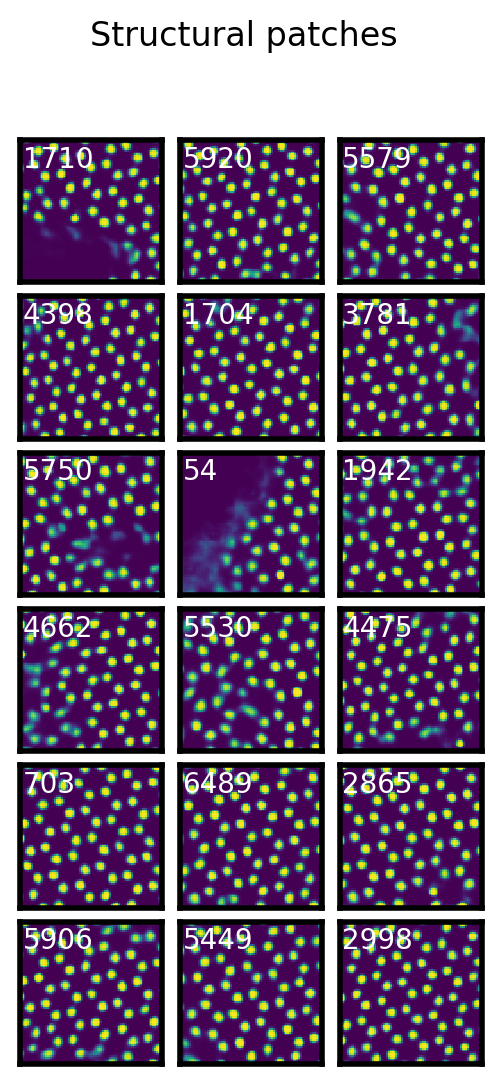

In [14]:
#plot examples of patches
fig, axes = plt.subplots(6, 3, figsize=(3, 6), dpi = 200,
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

fig.suptitle('Structural patches')

for ax in axes.flat:
    i = np.random.randint(len(imstack))
    ax.imshow(imstack[i], interpolation='nearest')
    ax.text(1, 15, str(i), color='white')

In [15]:
#construct image stack and loader for VAE
vae_data = torch.tensor(imstack).float()
vae_loader = pv.utils.init_dataloader(vae_data, batch_size=50)

In [16]:
# train VAE using the constructed stack of subimages
in_dim = (ws_1, ws_1)

vae_vanilla = pv.models.iVAE(in_dim, latent_dim=2, invariances=['r','t'],
                      sampler_d='continuous_bernoulli', seed=42)
# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae_vanilla)
training_losses = []

# Train for n epochs:
for e in range(200):
    trainer.step(vae_loader)
    trainer.print_statistics()
    # training_loss = trainer.loss
    # training_losses.append(training_loss)

Epoch: 1 Training loss: -4471.9465
Epoch: 2 Training loss: -4673.1291
Epoch: 3 Training loss: -4699.2804
Epoch: 4 Training loss: -4771.5405
Epoch: 5 Training loss: -4903.4087
Epoch: 6 Training loss: -4950.1486
Epoch: 7 Training loss: -4968.2768
Epoch: 8 Training loss: -4977.9807
Epoch: 9 Training loss: -4988.2925
Epoch: 10 Training loss: -5000.9971
Epoch: 11 Training loss: -5005.9992
Epoch: 12 Training loss: -5007.2002
Epoch: 13 Training loss: -5016.3143
Epoch: 14 Training loss: -5018.1282
Epoch: 15 Training loss: -5019.9220
Epoch: 16 Training loss: -5021.8673
Epoch: 17 Training loss: -5022.6683
Epoch: 18 Training loss: -5027.8746
Epoch: 19 Training loss: -5029.6228
Epoch: 20 Training loss: -5031.6339
Epoch: 21 Training loss: -5032.8254
Epoch: 22 Training loss: -5033.8571
Epoch: 23 Training loss: -5035.6980
Epoch: 24 Training loss: -5037.1391
Epoch: 25 Training loss: -5038.0141
Epoch: 26 Training loss: -5040.9788
Epoch: 27 Training loss: -5037.4250
Epoch: 28 Training loss: -5038.2486
E

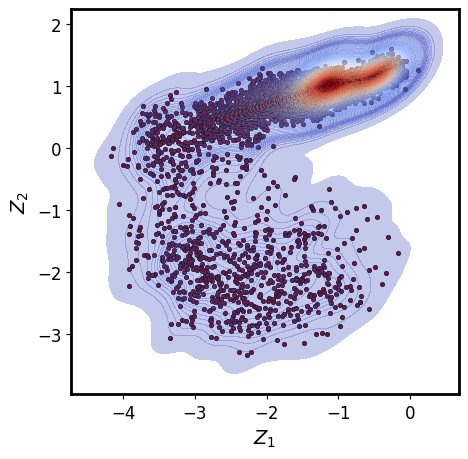

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

z_mean_std, z_std = vae_vanilla.encode(vae_data)

# Creating a figure with seaborn
plt.figure(figsize=(5, 5), facecolor='white')


# Scatter plot
sc = plt.scatter(z_mean_std[:, -1], z_mean_std[:, -2],  s=10, c='maroon', alpha = 1, edgecolor='k', linewidth=0.5)

# KDE plot
sns.kdeplot(x=z_mean_std[:, -1], y=z_mean_std[:, -2], cmap="coolwarm", thresh = 0.001, levels = 100,  alpha = 0.3, fill=True)


# Adding labels and title
plt.xlabel("$Z_1$", fontsize=14)
plt.ylabel("$Z_2$", fontsize=14)
# plt.title("Scatter Plot of Latent Variables with KDE", fontsize=16, pad=15)



# Increasing size of ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Displaying the plot
plt.show()


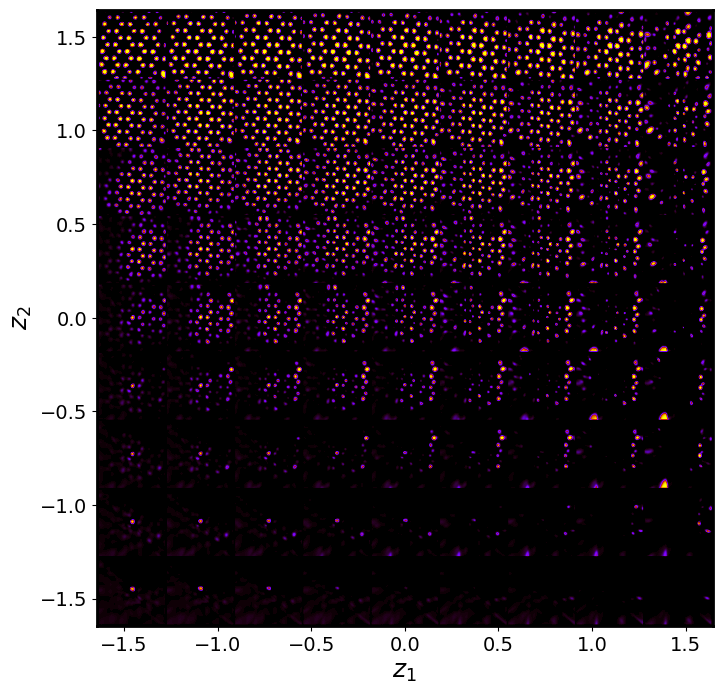

tensor([[[3.7250e-06, 6.0362e-07, 2.6035e-07,  ..., 1.0667e-13,
          6.4845e-16, 5.7935e-17],
         [1.5907e-07, 2.5324e-09, 2.2327e-10,  ..., 6.2739e-13,
          2.1973e-14, 1.5172e-14],
         [7.7064e-09, 2.5402e-11, 3.3665e-13,  ..., 4.5186e-11,
          2.5862e-12, 5.1798e-12],
         ...,
         [1.1470e-08, 2.1744e-07, 1.8786e-06,  ..., 9.8919e-01,
          9.9269e-01, 9.8889e-01],
         [5.0249e-09, 7.0175e-08, 4.2026e-07,  ..., 9.0186e-01,
          9.4456e-01, 9.2011e-01],
         [8.0514e-10, 8.0724e-09, 3.5847e-08,  ..., 1.1961e-01,
          3.8471e-01, 3.9487e-01]],

        [[2.2057e-06, 9.4156e-08, 3.9136e-09,  ..., 5.0921e-17,
          3.5672e-16, 1.9921e-13],
         [1.5545e-07, 3.2919e-09, 2.6906e-11,  ..., 6.3362e-15,
          9.2939e-14, 4.7126e-11],
         [1.5822e-08, 1.2746e-10, 2.4603e-13,  ..., 1.8046e-12,
          3.3871e-11, 5.9042e-09],
         ...,
         [2.6198e-11, 7.7555e-10, 3.0067e-08,  ..., 9.9596e-01,
          9.946

In [18]:
vae_vanilla.manifold2d(d = 9) # sigma = 0.6

# SIFTVAE

In [19]:
# plotting utility
from pyroved.utils import generate_latent_grid, plot_img_grid
from typing import Optional, Tuple, Union, List
from typing import Union, List, Tuple
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

#*****************************************************manifold2d
def plot_img_grid_custom(imgdata: torch.Tensor, d: int, ws: int,
                  **kwargs: Union[str, int, List[float]]) -> None:
    """
    Plots a *d*-by-*d* square grid of 2D images
    """
    if imgdata.ndim < 3:
        raise AssertionError("Images must be passed as a 3D or 4D tensor")
    imgdata = imgdata[:, None] if imgdata.ndim == 3 else imgdata
    grid = make_grid(imgdata, nrow=d,
                     padding=kwargs.get("padding", 2),
                     pad_value=kwargs.get("pad_value", 0)).cpu()
    extent = kwargs.get("extent")
    # Put on cpu in case all tensors are created on gpu by default
    extent_ = [e.cpu() for e in extent]
    plt.figure(figsize=(4, 5), dpi = 200)
    plt.imshow(grid[0].squeeze(), cmap=kwargs.get("cmap", "gnuplot"),
               origin=kwargs.get("origin", "upper"),
               extent=extent_)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$z_1$", fontsize=18)
    plt.ylabel("$z_2$", fontsize=18)
    plt.text(-1.75, 1.75, f'ω: {ws}', fontsize=15, fontweight = 'bold', verticalalignment='top', color='white',
        bbox=dict(boxstyle="round", facecolor='black', edgecolor='none'))
    # plt.title(f"2dmanifold_window_size{ws}", fontsize=18)
    plt.savefig(f"2dmanifold_window_size{ws}")
    plt.show()


def get_custom_manifold2d(local_vae, d: int, ws=1):
    """
    Plots a learned latent manifold in the data space

    Args:
        d: Grid size
        plot: Plots the generated manifold (Default: True)
        y: Conditional "property" vector (e.g. one-hot encoded class vector)
        kwargs: Keyword arguments include custom min/max values
                for grid boundaries passed as 'z_coord'
                (e.g. z_coord = [-3, 3, -3, 3]), 'angle' and
                'shift' to condition a generative model on, and plot parameters
                ('padding', 'pad_value', 'cmap', 'origin', 'ylim')
    """
    z, (grid_x, grid_y) = generate_latent_grid(d, z_coord = [-2,2,-2,2])
    z = [z]

    loc = local_vae.decode(*z, )

    plot_img_grid_custom(
                loc, d,ws = ws,
                extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()])



    return loc


#**************************************************************************latent representation with KDE

def plot_latent_rep_with_kde(z_mean, z_sd, ws, folder):


    fig, _ = plt.subplots(figsize = (4 , 4), dpi = 200)
    os.makedirs(folder, exist_ok=True)
    im =plt.scatter(z_mean[:,-2], z_mean[:,-1], s = 0.5, c = 'red', edgecolors='black',linewidths=0.1 )
    sns.kdeplot(x=z_mean[:, -2], y=z_mean[:, -1], fill=True, thresh=0.01, levels=100, cmap="autumn", shade=True, alpha=0.3)
    plt.xlim([-4,4])
    plt.ylim([-4,4])
    plt.xlabel("$z_1$", fontsize=12)
    plt.ylabel("$z_2$", fontsize=12)
    plt.text(-3.5, 3.5, f'ω: {ws}', fontsize=12, verticalalignment='top', color='black')
    plt.tight_layout()
    # plt.title(f"Latent distribution for window_size{ws}", fontsize=10)
    plt.savefig(f"{folder}/latent_distribution_window_size{ws}.png")


#****************************************plot latent images

def visualize_latent_images(frame, com_all, frames_all, lattice_coord, z1, z3, STEM_real, ws, folder):
    """
    Visualizes the latent space encodings on the raw STEM image for a given frame.

    Parameters:
    - frame: The frame number to visualize.
    - com_all: Array containing coordinates for all frames.
    - frames_all: Array indicating the frame number for each coordinate in com_all.
    - lattice_coord: List of arrays containing lattice coordinates for each frame.
    - z1: Array of latent variables (image) related to the encoded angle.
    - z3: Array of latent variables (image) with dimensions for different features.
    - STEM_real: Array containing the raw STEM images.

    Returns:
    - None: Displays a matplotlib figure with the visualization.
    """
    os.makedirs(folder, exist_ok=True)
    com_i = com_all[frames_all == frame]  # get coordinates for this frame
    com_i_Si = lattice_coord[frame]  # get Si coordinates for plotting
    com_i_Si = com_i_Si[com_i_Si[:, -1] == 1.]
    z1_i = z1[frames_all == frame]  # get latent variables (image) for this frame
    z3_i = z3[frames_all == frame]  # get latent variables (image) for this frame

    col_min0 = z1.min()
    col_max0 = z1.max()
    col_min1 = z3[:, 0].min()
    col_max1 = z3[:, 0].max()
    col_min2 = z3[:, 1].min()
    col_max2 = z3[:, 1].max()

    fig, ax = plt.subplots(1, 3, figsize=(30, 10))
    ax[0].imshow(STEM_real[frame, ..., 0], cmap="gray")
    ax[0].scatter(com_i[:, 1], com_i[:, 0], c=z1_i, s=15,
                  cmap="jet", vmin=col_min0, vmax=col_max0)
    ax[0].set_title("Encoded angle", fontsize=18)
    ax[1].imshow(STEM_real[frame, ..., 0], cmap="gray")
    ax[1].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 0], s=15,
                  cmap="jet", vmin=col_min1, vmax=col_max1)
    ax[1].set_title("Latent variable 1", fontsize=18)
    ax[2].imshow(STEM_real[frame, ..., 0], cmap="gray")
    ax[2].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 1], s=15,
                  cmap="jet", vmin=col_min2, vmax=col_max2)
    ax[2].set_title("Latent variable 2", fontsize=18)
    for _ax in fig.axes:
        _ax.scatter(com_i_Si[:, 1], com_i_Si[:, 0], s=35, c='Red')
        _ax.axis(False)
    cbar = ax[0].figure.colorbar(ax[0].collections[0], ax=ax[0], orientation='vertical', shrink = 0.7)
    cbar.set_label('Encoded angle value', rotation=270, labelpad=16, fontsize = 16)
    cbar = ax[1].figure.colorbar(ax[1].collections[0], ax=ax[1], orientation='vertical', shrink = 0.7)
    cbar.set_label('Latent variable 1 value', rotation=270, labelpad=16, fontsize = 16)
    cbar = ax[2].figure.colorbar(ax[2].collections[0], ax=ax[2], orientation='vertical', shrink = 0.7)
    cbar.set_label('Latent variable 2 value', rotation=270, labelpad=16, fontsize = 16)

    fig.suptitle(f"latent_images_windowsize{ws}_for frame{frame}", fontsize=20)
    plt.savefig(f"{folder}/{frame}latent_image_window_size{ws}.png")
    plt.show()


# Example of calling the function:
# visualize_latent_encodings(frame, com_all, frames_all, lattice_coord, z1, z3, STEM_real)


In [20]:
def calculate_dispersion(latent_vars):
  """
  Calculates the mean and variance (dispersion) of latent variables.

  Args:
      latent_vars (numpy.ndarray): Array containing latent variables (data points x dimensions).

  Returns:
      tuple: A tuple containing the mean vector and variance array.
  """
  mean_latent_vector = np.mean(latent_vars, axis=0)
  variance = np.var(latent_vars, axis=0)
  return mean_latent_vector, variance

def calculate_dispersion_per_frame(latent_vars, frames_all):
  """
  Calculates the mean and variance of latent variables for each frame.

  Args:
      latent_vars (numpy.ndarray): Array containing latent variables (data points x dimensions).
      frames_all (list or array): List or array indicating the frame number for each data point.

  Returns:
      list: A list containing tuples of (mean_vector, variance_array) for each frame.
  """
  dispersions_per_frame = []
  for frame in np.unique(frames_all):
    frame_data = latent_vars[frames_all == frame]  # Select data points for the current frame
    mean_vector, variance_array = calculate_dispersion(frame_data)
    # dispersions_per_frame.append((mean_vector, variance_array))
  return mean_vector, variance_array


In [21]:
ws = np.arange(10,80,10)

In [22]:
# what window sizes are you interested in?
# ws = np.arange(10, 80, 2)
from tqdm import tqdm
print(ws)
window_size = ws[-1]   # max windows size
s = aoi.stat.imlocal(
    np.sum(decoded_imgs[..., :-1], -1)[..., None], # convert to a single channel (no background)
    lattice_coord, # Coodinates array, acts as the mid-point of the cropped sub-images
    window_size, 0)

#Setting the train loader
imstack = tt(s.imgstack[:,None,:,:, 0])#
frames_all = s.imgstack_frames # will need for plotting VAE results
com_all = s.imgstack_com # will need for plotting VAE results

# make new lattice coordinate as changing window size might lead to loss of atoms so lets use the lasgest windows size and get atoms for that and that will be consisiten always
lattice_coord_largest = {}
for frame in np.unique(frames_all):
    temp = com_all[frames_all == frame]
    ## Add another column to lattice_coord_largest[frame] to represent atom type all_zeros
    zeros_column = np.zeros((temp.shape[0], 1))

    # Append the column of zeros to the original array to make its shape (1425, 3)
    lattice_coord_largest[frame] = np.hstack((temp, zeros_column))


[10 20 30 40 50 60 70]


In [23]:
frames_all.shape

(7531,)

In [24]:
window_size_consistent = 40
# Ititialize model
in_dim = (window_size_consistent, window_size_consistent)
rvae_super = pv.models.iVAE(in_dim, latent_dim=2,   # Number of latent dimensions other than the invariancies
                               hidden_dim_e = [512, 512],   # corresponds to the number of neurons in the hidden layers of the encoder
                               hidden_dim_d = [512, 512],   # corresponds to the number of neurons in the hidden layers of the decoder
                               invariances=['r', 't'], seed=0)
# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(rvae_super)


In [25]:
# rvae_super.load_weights("/content/weight.pt")

In [26]:
array_evolution = []
mean_z = []
mean_z_w = []
disperse_z = []
disperse_z_w = []
for i,j in tqdm(enumerate(ws)):
    print("data curation started")
    s = get_s(lattice_coord_largest, j, decoded_imgs)
    imstack, frames_all, com_all = get_imstack_frames_com_all(s, j)
    resized_imstack = resize_image_stack(imstack, size=(40, 40))
    final_train, final_trainloader = get_data_loader(resized_imstack, batch_size = 120)
    print("data curation ended, shape=", imstack.shape, frames_all.shape, com_all.shape)
    print("window_size", j)
    for e in range(10):
        trainer.step(final_trainloader, scale_factor=3)
        trainer.print_statistics()
        # rvae_super.save_weights(f"weight_ws{j}")
    # files.download(f"/content/weight{j}.pt")

    z_mean, z_sd = rvae_super.encode(final_train)
    array_evolution.append(z_mean)
    # plot latent manifold:
    get_custom_manifold2d(rvae_super,d = 9, ws = j);   # d corresponds to the number of points sampled in each latent dimension
    # plot latent rep
    plot_latent_rep_with_kde(z_mean, z_sd, ws = j,  folder = "dist")
    # plot latent images
    # z1, z2, z3 = z_mean[:,0], z_mean[:, 1:3], z_mean[:, 3:]
    # visualize_latent_images(0, com_all, frames_all, lattice_coord, z1, z3, STEM_real, ws =j, folder = "latent_img")#lattice_coord_largest_ws

    # visualize_latent_images(2, com_all, frames_all, lattice_coord, z1, z3, STEM_real, ws =j)
    # visualize_latent_images(4, com_all, frames_all, lattice_coord, z1, z3, STEM_real, ws =j)

rvae_super.save_weights(f"weight_running_VAE")
np.savez(f"array_evolution.npz", array_evolution= np.array(array_evolution))
# files.download(f"/content/array_evolution{j}.npz")

Output hidden; open in https://colab.research.google.com to view.

In [27]:
np.array(array_evolution).shape

(7, 7531, 5)

In [28]:
np.savez("array_evolution.npz", array_evolution= np.array(array_evolution))

# Now postprocessing evolution of window size

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import cv2
import seaborn as sns
from scipy import stats
import matplotlib
matplotlib.rcParams['axes.linewidth'] = 2

In [ ]:
#This link downloads the numpy array containing the latent variables when trained over all 50 frames of the dataset

# ! gdown https://drive.google.com/uc?id=1AmEzBDwkLo1u3HmwRBmHwphY-3PM4ZQh

Downloading...
From (original): https://drive.google.com/uc?id=1AmEzBDwkLo1u3HmwRBmHwphY-3PM4ZQh
From (redirected): https://drive.google.com/uc?id=1AmEzBDwkLo1u3HmwRBmHwphY-3PM4ZQh&confirm=t&uuid=17c1f8e7-36e3-4c6c-9870-4c882fb3ba20
To: /content/array_evolution78.npz
100% 42.1M/42.1M [00:00<00:00, 57.1MB/s]


In [30]:
array_evolution = np.load("/content/array_evolution.npz")["array_evolution"]
array_evolution.shape

(7, 7531, 5)

In [31]:
array_evolution = np.array(array_evolution)

Text(0, 0.5, 'Angle encoding')

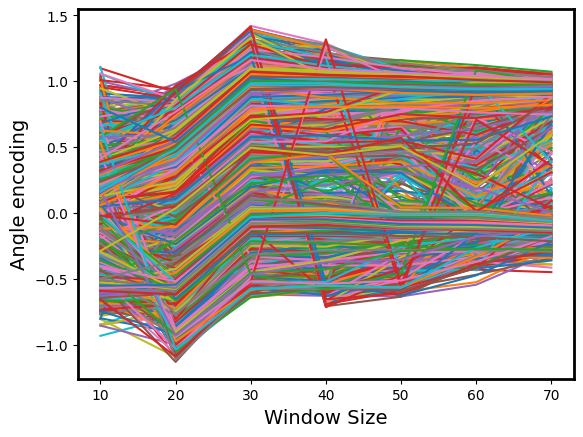

In [32]:
plt.plot(ws, array_evolution[:,:,0]);
plt.xlabel("Window Size", fontsize = 14)
plt.ylabel("Angle encoding", fontsize = 14)
# Adding a title to the plot
# plt.title("Evolution of Angle Latent Variables for all atoms")

Text(0, 0.5, 'Translation - X encoding')

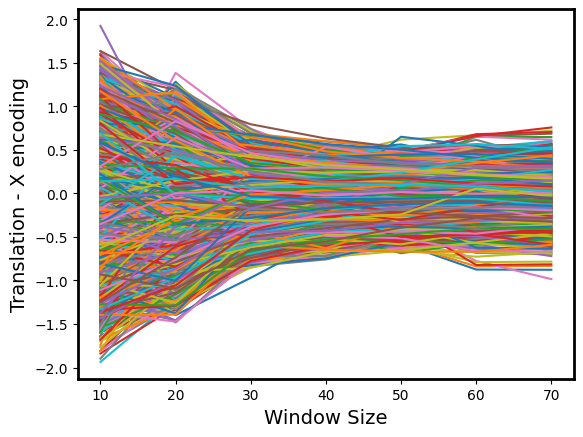

In [33]:
plt.plot(ws, array_evolution[:,:,1]);
plt.xlabel("Window Size", fontsize = 14)
plt.ylabel("Translation - X encoding", fontsize = 14)
# Adding a title to the plot
# plt.title("Evolution of translation-X Latent Variables for all atoms")

Text(0, 0.5, 'Translation - Y encoding')

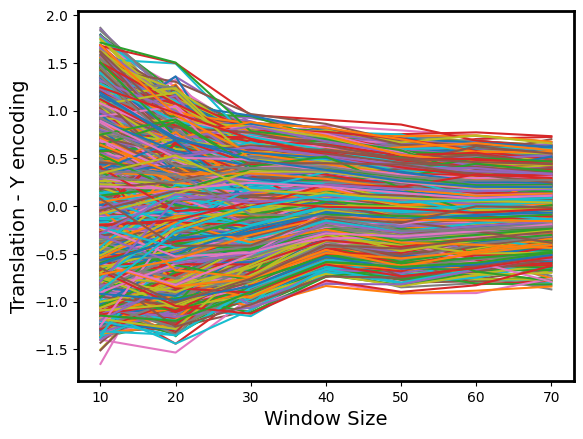

In [34]:
plt.plot(ws, array_evolution[:,:,2]);
plt.xlabel("Window Size", fontsize = 14)
plt.ylabel("Translation - Y encoding", fontsize = 14)
# Adding a title to the plot
# plt.title("Evolution of translation-Y Latent Variables for all atoms")

Text(0, 0.5, 'L1')

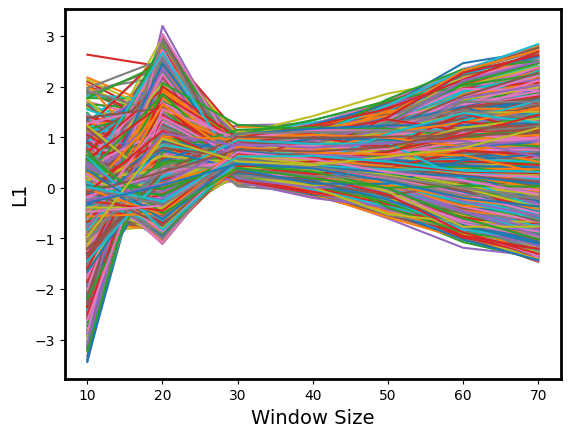

In [35]:
plt.plot(ws, array_evolution[:,:,3]);
plt.xlabel("Window Size", fontsize = 14)
plt.ylabel("L1", fontsize = 14)
# Adding a title to the plot
# plt.title("Evolution of 1st Latent Variables for all atoms")

Text(0, 0.5, 'L2')

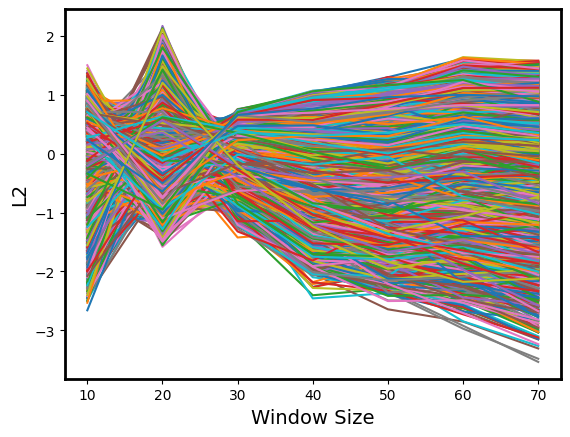

In [36]:
plt.plot(ws, array_evolution[:,:,4]);
plt.xlabel("Window Size", fontsize = 14)
plt.ylabel("L2", fontsize = 14)
# Adding a title to the plot
# plt.title("Evolution of 2nd Latent Variables for all atoms")

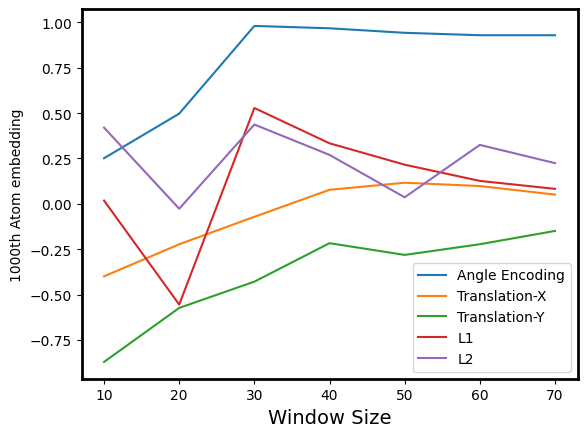

In [37]:
# plot evolution of the 1000th atom
chosen_atom = 1000
latent_variable_labels = ['Angle Encoding', 'Translation-X', 'Translation-Y', 'L1', 'L2']

for i in range(5):
    plt.plot(ws,array_evolution[:, chosen_atom - 1, i], label=f"{latent_variable_labels[i]}")

# Labeling the axes
plt.xlabel("Window Size", fontsize = 14)
plt.ylabel("1000th Atom embedding", )

# Adding a legend
plt.legend(loc='best')

# Adding a title to the plot
# plt.title("Evolution of Latent Variables for Atom #1000")

# Show the plot
plt.show()


In [38]:
array_evolution.shape

(7, 7531, 5)

In [39]:
frames_all.shape

(7531,)

In [40]:
mean_z = []
mean_z1_w = []
disperse_z = []
disperse_z1_w = []
z1 = array_evolution[:,:,-2]
for w in range(7):
  mean_z = []
  disperse_z = []
  for frame in np.unique(frames_all):

    frame_data = z1[w, frames_all == frame]  # Select data points for the current frame
    mean_vector, variance_array = frame_data.mean(), frame_data.var()
    mean_z.append(mean_vector)# 50
    disperse_z.append(variance_array)
  mean_z1_w.append(mean_z)
  disperse_z1_w.append(disperse_z)

In [41]:
mean_z = []
mean_z2_w = []
disperse_z = []
disperse_z2_w = []
z1 = array_evolution[:,:,-1]
for w in range(7):
  mean_z = []
  disperse_z = []
  for frame in np.unique(frames_all):

    frame_data = z1[w, frames_all == frame]  # Select data points for the current frame
    # frame_data = frame_data.detach().cpu().numpy()
    # mean_vector, variance_array = calculate_dispersion(frame_data)
    mean_vector, variance_array = frame_data.mean(), frame_data.var()
    mean_z.append(mean_vector)# 50
    disperse_z.append(variance_array)
  mean_z2_w.append(mean_z)
  disperse_z2_w.append(disperse_z)

In [42]:
mean_z1_w = np.array(mean_z1_w)
disperse_z1_w = np.array(disperse_z1_w)
mean_z2_w = np.array(mean_z2_w)
disperse_z2_w = np.array(disperse_z2_w)

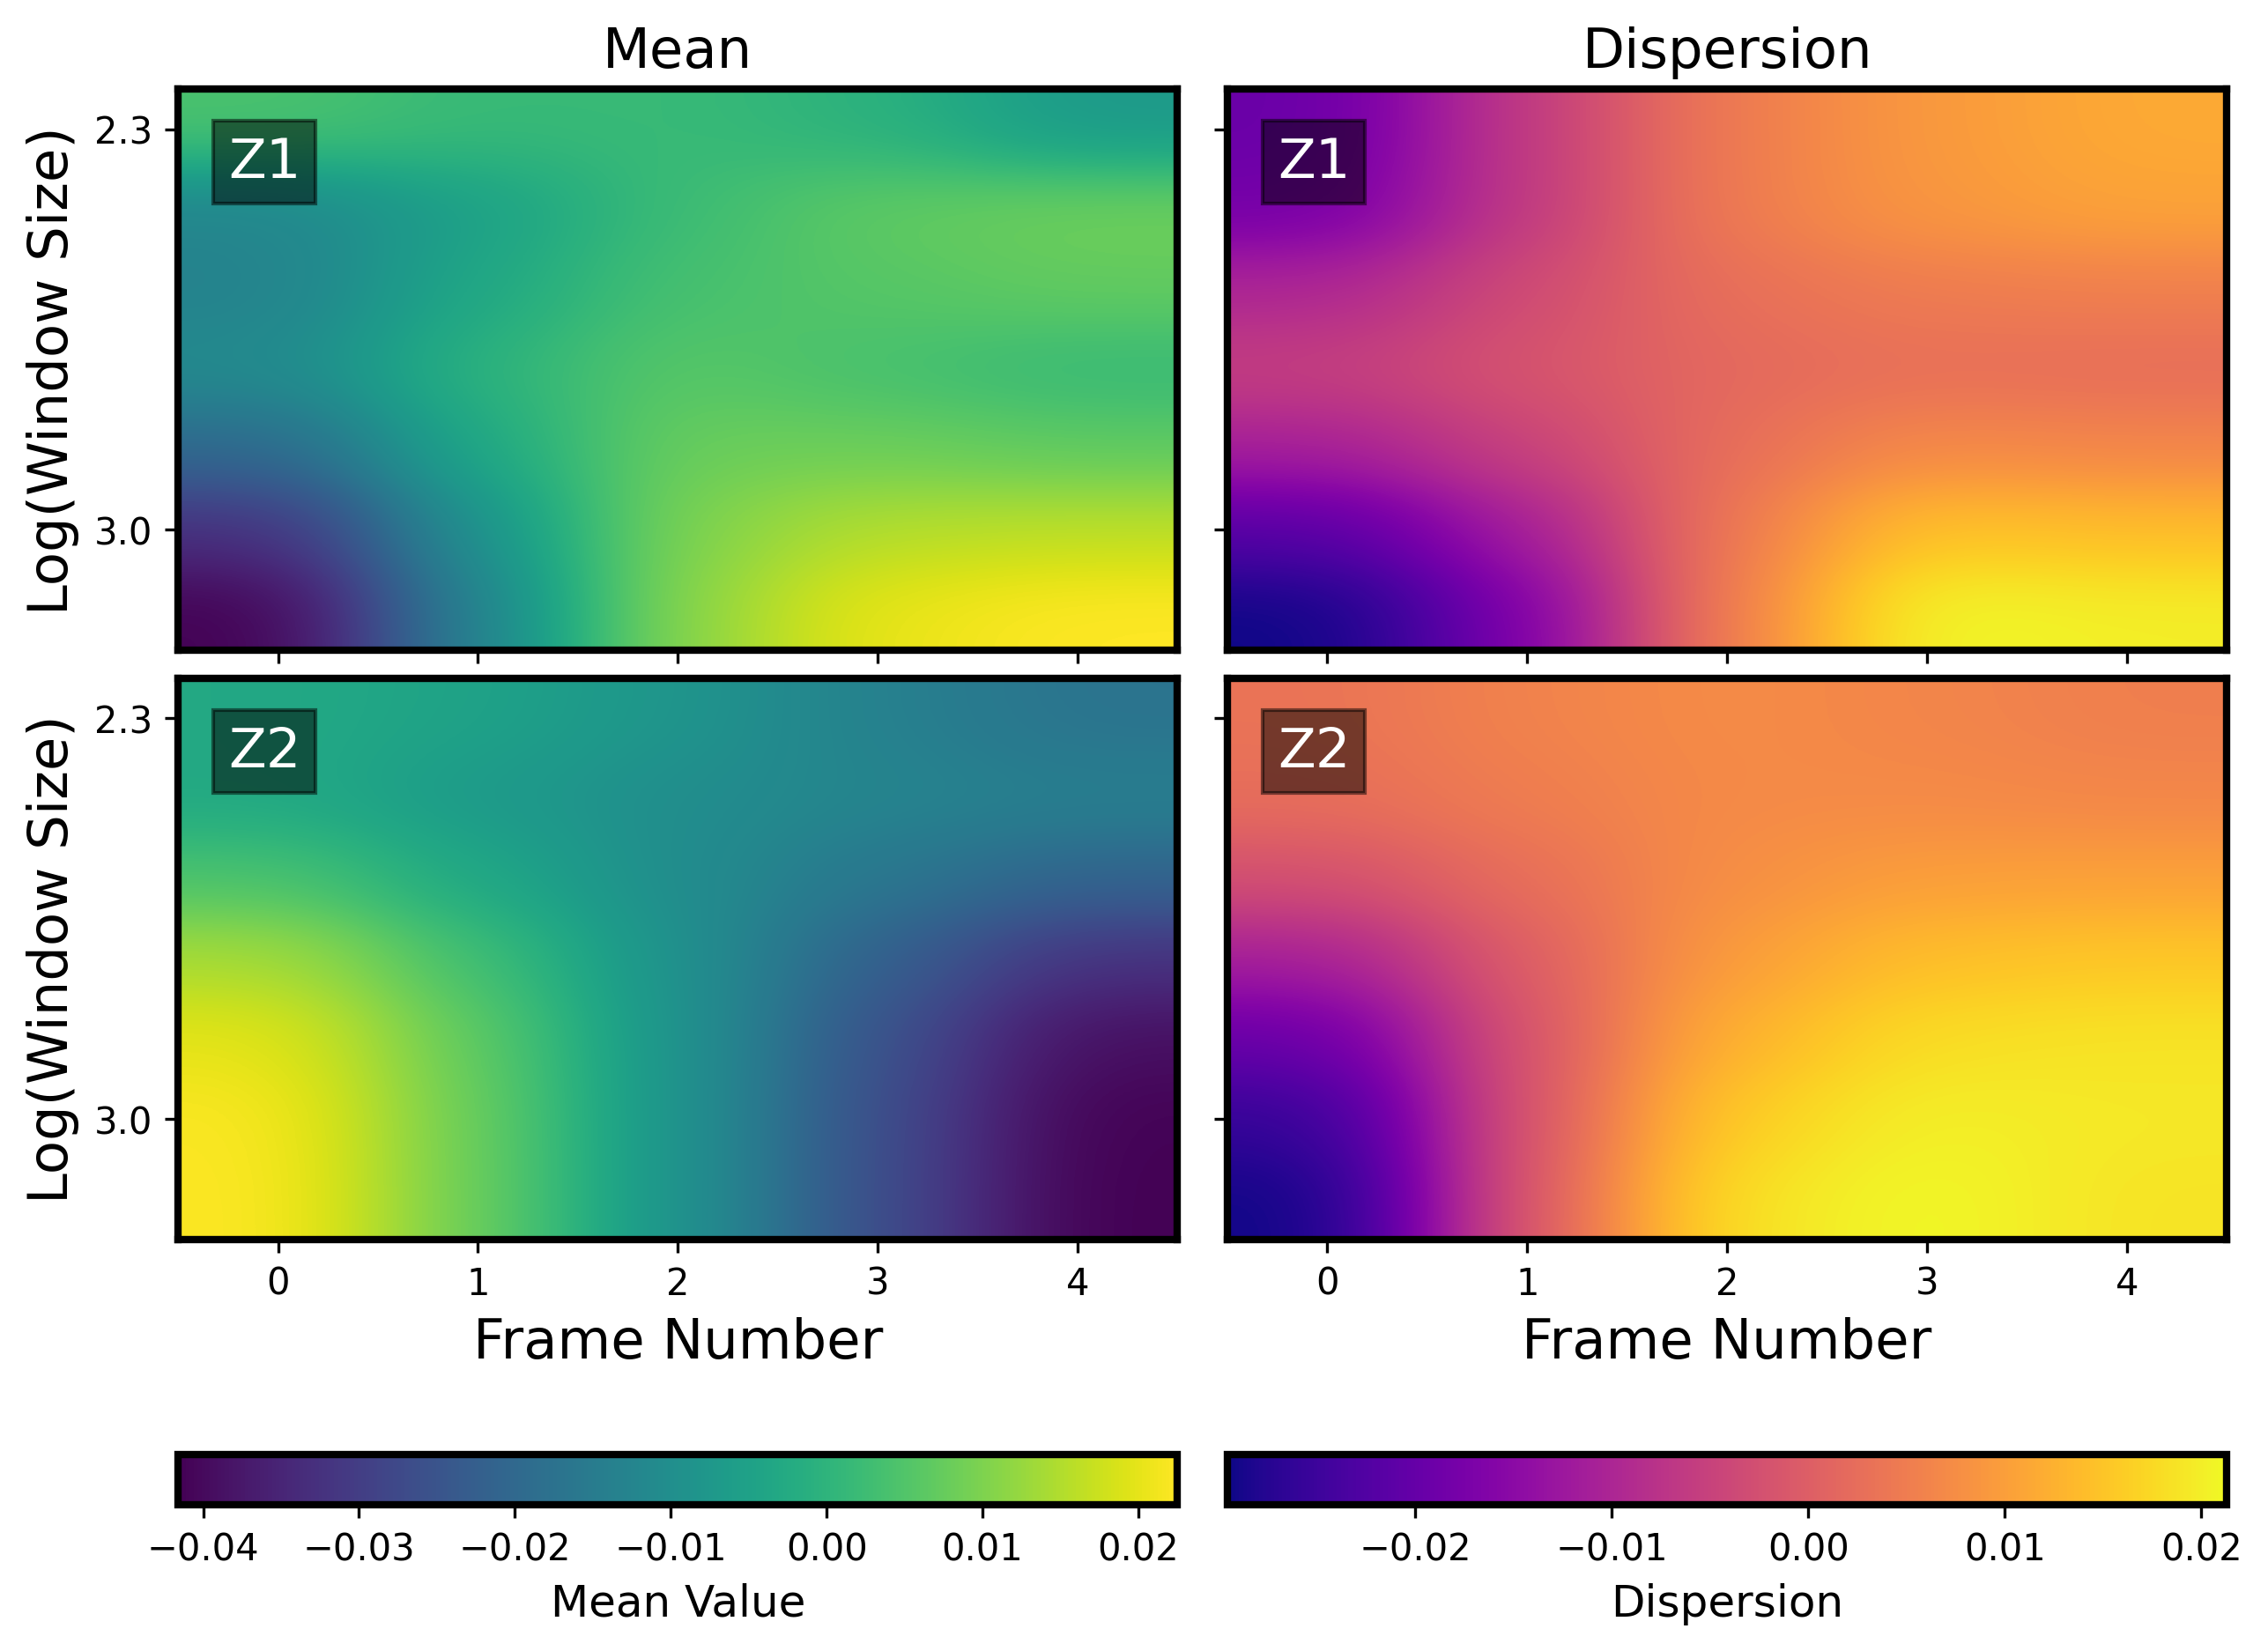

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Function to subtract the mean of each line
def subtract_line_mean(data):
    mean_subtracted = data - np.mean(data, axis=1, keepdims=True)
    return mean_subtracted

log_window_sizes = np.log(ws)
step = 5


# Subtract the mean of each line to highlight variations
mean_z1_w_subtracted = subtract_line_mean(mean_z1_w)
mean_z2_w_subtracted = subtract_line_mean(mean_z2_w)
disperse_z1_w_subtracted = subtract_line_mean(disperse_z1_w)
disperse_z2_w_subtracted = subtract_line_mean(disperse_z2_w)

# Apply Gaussian filter for smoothing
sigma = 1  # Adjust sigma for smoothing effect
mean_z1_w_smooth = gaussian_filter(mean_z1_w_subtracted, sigma=sigma)
mean_z2_w_smooth = gaussian_filter(mean_z2_w_subtracted, sigma=sigma)
disperse_z1_w_smooth = gaussian_filter(disperse_z1_w_subtracted, sigma=sigma)
disperse_z2_w_smooth = gaussian_filter(disperse_z2_w_subtracted, sigma=sigma)

fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=300, sharex=True, sharey=True)

# Mean plot 1
im1 = axes[0, 0].imshow(mean_z1_w_smooth, interpolation='gaussian', cmap='viridis')
axes[0, 0].set_aspect('auto')
axes[0, 0].set_ylabel('Log(Window Size)', fontsize=15)
yticks = range(0, mean_z1_w.shape[0], step)
axes[0, 0].set_yticks(yticks)
axes[0, 0].set_yticklabels(np.round(log_window_sizes[:len(yticks)], 2))
axes[0, 0].set_title('Mean', fontsize=15)
# axes[0, 0].grid(True, linestyle='--', alpha=0.5)
axes[0, 0].text(-0.25, 0.6, 'Z1', fontsize=15, color='white', bbox=dict(facecolor='black', alpha=0.5))

# Mean plot 2
im2 = axes[1, 0].imshow(mean_z2_w_smooth, interpolation='gaussian', cmap='viridis')
axes[1, 0].set_aspect('auto')
axes[1, 0].set_ylabel('Log(Window Size)', fontsize=15)
axes[1, 0].set_xlabel('Frame Number', fontsize=15)
# axes[1, 0].grid(True, linestyle='--', alpha=0.5)
axes[1, 0].text(-0.25, 0.6, 'Z2', fontsize=15, color='white', bbox=dict(facecolor='black', alpha=0.5))

# Dispersion plot 1
im3 = axes[0, 1].imshow(disperse_z1_w_smooth, interpolation='gaussian', cmap='plasma')
axes[0, 1].set_aspect('auto')
axes[0, 1].set_title('Dispersion', fontsize=15)
# axes[0, 1].grid(True, linestyle='--', alpha=0.5)
axes[0, 1].text(-0.25, 0.6, 'Z1', fontsize=15, color='white', bbox=dict(facecolor='black', alpha=0.5))

# Dispersion plot 2
im4 = axes[1, 1].imshow(disperse_z2_w_smooth, interpolation='gaussian', cmap='plasma')
axes[1, 1].set_aspect('auto')
axes[1, 1].set_xlabel('Frame Number', fontsize=15)
# axes[1, 1].grid(True, linestyle='--', alpha=0.5)
axes[1, 1].text(-0.25, 0.6, 'Z2', fontsize=15, color='white', bbox=dict(facecolor='black', alpha=0.5))

# Adjust layout
plt.subplots_adjust(hspace=0.05, wspace=0.05, bottom=0.2)

# Add colorbars at the bottom
cbar1 = fig.colorbar(im1, ax=[axes[0, 0], axes[1, 0]], orientation='horizontal', fraction=0.05, pad=0.15, shrink=1)
cbar2 = fig.colorbar(im3, ax=[axes[0, 1], axes[1, 1]], orientation='horizontal', fraction=0.05, pad=0.15, shrink=1)

cbar1.set_label('Mean Value', fontsize=12)
cbar2.set_label('Dispersion', fontsize=12)

plt.show()


# Further lets do some dimensionality reduction to get important features and visualize them on atoms
idea is to play with two variables:
1. choose a random variable-> rv = 1 [ranges from 0 to 4 for rtvae]

2. play with nc in dimension reduction

3. visualizing the frames with feature values on each atom

## 1. choose a random variable -> rv = 1 [ranges from 0 to 4 for rtvae]

In [53]:
array_evolution_transposed  = array_evolution.transpose(1, 2, 0)
print(array_evolution_transposed.shape)

X_vec = array_evolution_transposed.copy()
d1, d2, d3 = X_vec.shape

# choose a random variable
rv = 4
X_vec = X_vec[:, rv, :]# chosen a latent variable
print("shape of features to undergo dimensionality reduction", X_vec.shape)

(7531, 5, 7)
shape of features to undergo dimensionality reduction (7531, 7)


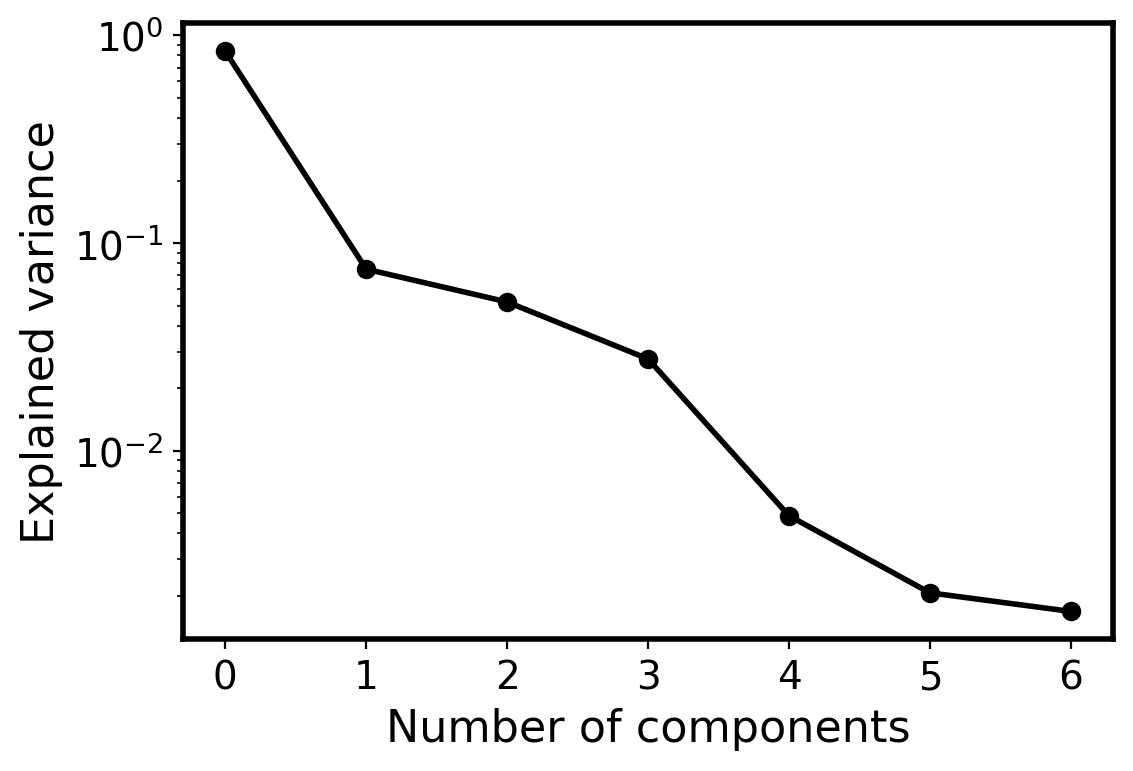

In [57]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 7)
pca.fit(X_vec)
plt.figure(figsize=(6, 4), dpi = 200)
plt.plot(pca.explained_variance_ratio_[0:150], '-o', linewidth=2, c = 'black')
plt.xlabel('Number of components', fontsize = 16)
plt.ylabel('Explained variance', fontsize = 16)

plt.tick_params(labelsize = 14)
plt.yscale('log')

## 2. play with nc in dimension reduction -> default 10

In [60]:
# Select number of components
nc = 7

# Select decomposition type ('PCA' or 'NMF')
decomposition_type = 'PCA'

# Run decomposition
if decomposition_type == 'NMF':
    clf = decomposition.NMF(n_components=nc, random_state=42)
elif decomposition_type == 'PCA':
    clf = decomposition.PCA(n_components=nc, random_state=42)
else:
    raise NotImplementedError('Available methods: "PCA", "NMF"')
X_vec_t = clf.fit_transform(X_vec)
components = clf.components_
#components = components.reshape(nc, d3)
print(components.shape, X_vec_t.shape)

(7, 7) (7531, 7)


## 3. visualizing the frame with feature values on each atom-> choose a, b and c

In [61]:
#****************************************plot features on atoms images

def visualize_on_atoms(frame, com_all, frames_all, lattice_coord, z1, z2, z3, STEM_real, ws):
    """
    Visualizes the latent space encodings on the raw STEM image for a given frame.

    Parameters:
    - frame: The frame number to visualize.
    - com_all: Array containing coordinates for all frames.
    - frames_all: Array indicating the frame number for each coordinate in com_all.
    - lattice_coord: List of arrays containing lattice coordinates for each frame.
    - z1: Feature set one interested in
    - z2: Feature set two interested in
    - z3: Feature set three interested in
    - STEM_real: Array containing the raw STEM images.

    Returns:
    - None: Displays a matplotlib figure with the visualization.
    """
    com_i = com_all[frames_all == frame]  # get coordinates for this frame
    com_i_Si = lattice_coord[frame]  # get Si coordinates for plotting
    com_i_Si = com_i_Si[com_i_Si[:, -1] == 1.]
    z1_i = z1[frames_all == frame]  # get latent variables (image) for this frame
    z2_i = z3[frames_all == frame]  # get latent variables (image) for this frame
    z3_i = z3[frames_all == frame]

    col_min0 = z1.min()
    col_max0 = z1.max()
    col_min1 = z2.min()
    col_max1 = z2.max()
    col_min2 = z3.min()
    col_max2 = z3.max()

    fig, ax = plt.subplots(1, 3, figsize=(30, 10), dpi = 300)
    ax[0].imshow(STEM_real[frame, ..., 0], cmap="gray")
    ax[0].scatter(com_i[:, 1], com_i[:, 0], c=z1_i, s=15,
                  cmap="jet", vmin=col_min0, vmax=col_max0)
    ax[0].set_title("1st Features", fontsize=18)
    ax[1].imshow(STEM_real[frame, ..., 0], cmap="gray")
    ax[1].scatter(com_i[:, 1], com_i[:, 0], c=z2_i, s=15,
                  cmap="jet", vmin=col_min1, vmax=col_max1)
    ax[1].set_title("2nd Features", fontsize=18)
    ax[2].imshow(STEM_real[frame, ..., 0], cmap="gray")
    ax[2].scatter(com_i[:, 1], com_i[:, 0], c=z3_i, s=15,
                  cmap="jet", vmin=col_min2, vmax=col_max2)
    ax[2].set_title("3rd Features", fontsize=18)
    for _ax in fig.axes:
        _ax.scatter(com_i_Si[:, 1], com_i_Si[:, 0], s=35, c='Red')# fro silicon atoms
        _ax.axis(False)
    cbar = ax[0].figure.colorbar(ax[0].collections[0], ax=ax[0], orientation='vertical', shrink = 0.7)
    cbar.set_label('1st PCA component', rotation=270, labelpad=15, fontsize = 15)
    cbar = ax[1].figure.colorbar(ax[1].collections[0], ax=ax[1], orientation='vertical',  shrink = 0.7)
    cbar.set_label('2nd PCA component', rotation=270, labelpad=15, fontsize = 15)
    cbar = ax[2].figure.colorbar(ax[2].collections[0], ax=ax[2], orientation='vertical',  shrink = 0.7)
    cbar.set_label('3rd PCA component', rotation=270, labelpad=15, fontsize = 15)

    fig.suptitle(f"vizualize_features_on_atoms_for frame{frame}", fontsize=20)
    plt.savefig(f"vizualize_features_on_atoms_for frame{frame}.png")
    plt.show()


# Example of calling the function:
# visualize_latent_encodings(frame, com_all, frames_all, lattice_coord, z1, z3, STEM_real)


In [ ]:
"""
def visualize_on_atoms_v(frame, com_all, frames_all, lattice_coord, z1, z2, z3, STEM_real, ws):
    """
    Visualizes the latent space encodings on the raw STEM image for a given frame.

    Parameters:
    - frame: The frame number to visualize.
    - com_all: Array containing coordinates for all frames.
    - frames_all: Array indicating the frame number for each coordinate in com_all.
    - lattice_coord: List of arrays containing lattice coordinates for each frame.
    - z1: Feature set one interested in
    - z2: Feature set two interested in
    - z3: Feature set three interested in
    - STEM_real: Array containing the raw STEM images.

    Returns:
    - None: Displays a matplotlib figure with the visualization.
    """
    com_i = com_all[frames_all == frame]  # get coordinates for this frame
    com_i_Si = lattice_coord[frame]  # get Si coordinates for plotting
    com_i_Si = com_i_Si[com_i_Si[:, -1] == 1.]
    z1_i = z1[frames_all == frame]  # get latent variables (image) for this frame
    z2_i = z2[frames_all == frame]  # get latent variables (image) for this frame
    z3_i = z3[frames_all == frame]

    col_min0 = z1.min()
    col_max0 = z1.max()
    col_min1 = z2.min()
    col_max1 = z2.max()
    col_min2 = z3.min()
    col_max2 = z3.max()

    fig, ax = plt.subplots(3, 1, figsize=(5, 10), dpi=200)

    # Plot the 1st feature set
    ax[0].imshow(STEM_real[frame, ..., 0], cmap="gray")
    scatter0 = ax[0].scatter(com_i[:, 1], com_i[:, 0], c=z1_i, s=2.5,
                             cmap="jet", vmin=col_min0, vmax=col_max0)
    ax[0].set_title("1st PCA component", fontsize=15)

    # Plot the 2nd feature set
    ax[1].imshow(STEM_real[frame, ..., 0], cmap="gray")
    scatter1 = ax[1].scatter(com_i[:, 1], com_i[:, 0], c=z2_i, s=2.5,
                             cmap="jet", vmin=col_min1, vmax=col_max1)
    ax[1].set_title("2nd PCA component", fontsize=15)

    # Plot the 3rd feature set
    ax[2].imshow(STEM_real[frame, ..., 0], cmap="gray")
    scatter2 = ax[2].scatter(com_i[:, 1], com_i[:, 0], c=z3_i, s=2.5,
                             cmap="jet", vmin=col_min2, vmax=col_max2)
    ax[2].set_title("3rd PCA component", fontsize=15)

    for _ax in ax:
        _ax.scatter(com_i_Si[:, 1], com_i_Si[:, 0], s=2.5, c='Red')  # for silicon atoms
        _ax.axis(False)

    # Add colorbars
    cbar0 = fig.colorbar(scatter0, ax=ax[0], orientation='vertical', shrink=1)
    # cbar0.set_label('1st PCA component', rotation=270, labelpad=15, fontsize=15)
    cbar1 = fig.colorbar(scatter1, ax=ax[1], orientation='vertical', shrink=1)
    # cbar1.set_label('2nd PCA component', rotation=270, labelpad=15, fontsize=15)
    cbar2 = fig.colorbar(scatter2, ax=ax[2], orientation='vertical', shrink=1)
    # cbar2.set_label('3rd PCA component', rotation=270, labelpad=15, fontsize=15)

    # fig.suptitle(f"Visualize Features on Atoms for Frame {frame}", fontsize=20)
    plt.savefig(f"visualize_features_on_atoms_for_frame_{frame}.png")
    plt.show()

# Example of calling the function:
# visualize_on_atoms(frame, com_all, frames_all, lattice_coord, z1, z2, z3, STEM_real, ws)
"""

In [63]:
### Angle encoding
# here you can choose any varibles from
#choose_indexs
a, b, c = 0, 1, 2# can be values b/w 0 t0 nc --> here nc = 10

z1, z2, z3 = X_vec_t[:, a], X_vec_t[:, b], X_vec_t[:, c]#
visualize_on_atoms(0, com_all, frames_all, lattice_coord, z1, z2, z3, STEM_real, ws ="_all_")#lattice_coord_largest_ws

Output hidden; open in https://colab.research.google.com to view.

## optional - make video

In [ ]:
import cv2
import os
def create_video_recursive(base_folder, fps=30, frame_size=(640, 480), extension=".png", name = "video"):
    """
    Recursively creates video files from sequences of images in subfolders.

    Args:
        base_folder (str): The path to the base folder from where to start the recursive process.
        fps (int, optional): The frame rate of the output video. Defaults to 30.
        frame_size (tuple, optional): The size of the output video frames as a tuple of (width, height) in pixels. Defaults to (640, 480).
        extension (str, optional): The file extension of the image files to include in the video. Defaults to ".png".

    Returns:
        None
    """

    for folder_path, _, _ in os.walk(base_folder):
        # Get a list of all the image files in the current folder
        file_list = [f for f in os.listdir(folder_path) if f.endswith(extension)]


        if not file_list:
            continue

        output_file = os.path.join('/content/', f"{os.path.basename(folder_path)}{name}.avi")
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_file, fourcc, fps, frame_size)

        for file_name in sorted(file_list):  # Sorting to ensure images are processed in order
            # Read the image file
            img = cv2.imread(os.path.join(folder_path, file_name))

            # Resize the image to the output size
            img = cv2.resize(img, frame_size)

            # Write the image to the output video
            out.write(img)

        # Release the VideoWriter object
        out.release()

In [ ]:
create_video_recursive("/content/drive/MyDrive/Projects/SIFT VAE_PFM/Stem/sift_vae_graphene-20240503T165938Z-001/sift_vae_graphene/manifold",fps = 5,frame_size = (1200,1200), name = "manifold_stem_ws_step_2_5fps")

In [ ]:
create_video_recursive("/content/drive/MyDrive/Projects/SIFT VAE_PFM/Stem/sift_vae_graphene-20240503T165938Z-001/sift_vae_graphene/dist",fps = 5, frame_size = (1500,1200), name = "dist_stem_ws_step_2_5fps")

In [ ]:
create_video_recursive("/content/drive/MyDrive/Projects/SIFT VAE_PFM/Stem/sift_vae_graphene-20240503T165938Z-001/sift_vae_graphene/latent_img",fps = 5, frame_size = (3000,1000), name = "latent_img_stem_ws_step_2_5fps")

In [ ]:
!zip -r /content/dist2.zip /content/dist

  adding: content/dist/ (stored 0%)
  adding: content/dist/latent_distribution_window_size58.png (deflated 2%)
  adding: content/dist/latent_distribution_window_size25.png (deflated 2%)
  adding: content/dist/latent_distribution_window_size11.png (deflated 4%)
  adding: content/dist/latent_distribution_window_size41.png (deflated 15%)
  adding: content/dist/latent_distribution_window_size78.png (deflated 1%)
  adding: content/dist/latent_distribution_window_size32.png (deflated 1%)
  adding: content/dist/latent_distribution_window_size70.png (deflated 1%)
  adding: content/dist/latent_distribution_window_size13.png (deflated 2%)
  adding: content/dist/latent_distribution_window_size47.png (deflated 5%)
  adding: content/dist/latent_distribution_window_size19.png (deflated 2%)
  adding: content/dist/distmanifold_stem_ws_step_1_10fps.avi (deflated 4%)
  adding: content/dist/latent_distribution_window_size62.png (deflated 1%)
  adding: content/dist/latent_distribution_window_size57.png (d

Latent Variable evolution_ Frames

In [ ]:
array_evolution.shape

(35, 60171, 5)

In [ ]:

from matplotlib import ticker



fig, _ = plt.subplots(figsize = (5 , 4), dpi = 300)
im = plt.scatter(array_evolution[0,:,-1], array_evolution[0,:,-2], s=4, c = frames_all, cmap = 'plasma', edgecolors='black',linewidths=0.1)

plt.xlabel("$Z_1$")
plt.ylabel("$Z_2$")
cbar = fig.colorbar(im, shrink=.8)
cbar.set_label("Frame Number", fontsize=10)
cbar.ax.tick_params(labelsize=10)
cbar.ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))


In [ ]:
import os
import matplotlib.pyplot as plt

# Create the folder "frame_evolution" if it doesn't exist
os.makedirs("frame_evolution", exist_ok=True)  # Create folder if it doesn't exist

# Loop through all frames (0 to 6)
for frame_number in range(35):
  fig, _ = plt.subplots(figsize=(5, 4), dpi=300)  # Create figure and discard unused axis object

  # Access data for the current frame
  z1_f = array_evolution[frame_number, :, -1].flatten()
  z2_f = array_evolution[frame_number, :, -2].flatten()
 # Assuming f_num represents frame number

  # Create the scatter plot
  im = plt.scatter(z1_f, z2_f, s=4, c = frames_all, cmap = 'plasma', edgecolors='black',linewidths=0.1)

  # Add labels and title
  plt.xlabel("$Z_1$")
  plt.ylabel("$Z_2$")
  plt.title(f"Window Size: {ws[frame_number]}")  # Title with frame number (1-based indexing)

  # Create colorbar
  cbar = fig.colorbar(im, shrink=.8)
  cbar.set_label("Frame Number", fontsize=10)
  cbar.ax.tick_params(labelsize=10)
  cbar.ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

  # Save the plot as a PNG image
  filename = f"frame_evolution/WindowSize_{ws[frame_number]}.png"  # Filename with frame number
  plt.savefig(filename, bbox_inches='tight')  # Save with tight bounding box

  # Clear the plot for the next iteration
  plt.clf()

print("Plots saved to frame_evolution folder!")


In [ ]:
create_video_recursive("/content/frame_evolution", fps = 1, frame_size = (1500,1200), name = "Frame_evol_graphene")

In [ ]:
!zip -r /content/frame_evolution.zip /content/frame_evolution

## KDE -> PCA

In [64]:
array_evolution.shape

(7, 7531, 5)

In [65]:
# Extract the last two latent variables
z1 = array_evolution[:, :, -2]
z2 = array_evolution[:, :, -1]
print(z1.shape)

(7, 7531)


In [67]:
frames_all.shape

(7531,)

In [68]:
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def calculate_kde(z1, z2, grid_size=100):
    # Create grid for evaluation
    x_grid = np.linspace(z1.min(), z1.max(), grid_size)
    y_grid = np.linspace(z2.min(), z2.max(), grid_size)
    X, Y = np.meshgrid(x_grid, y_grid)
    grid_coords = np.vstack([X.ravel(), Y.ravel()])

    # Calculate KDE
    kde = stats.gaussian_kde(np.vstack([z1, z2]))
    Z = kde(grid_coords).reshape(grid_size, grid_size)

    return Z

# Initialize a list to store KDEs for each window size and frame
kdes = []

for w in range(z1.shape[0]):
    frame_kdes = []
    for frame in np.unique(frames_all):
        # Filter patches by frame
        z1_patch = z1[w, frames_all == frame]
        z2_patch = z2[w, frames_all == frame]

        kde = calculate_kde(z1_patch, z2_patch)
        frame_kdes.append(kde)

    kdes.append(frame_kdes)

kdes = np.array(kdes)


In [70]:
kdes.shape

(7, 5, 100, 100)

In [76]:
# Reshape KDEs for PCA
kde_a, kde_b  =  kdes.shape[0], kdes.shape[1]
flattened_kdes = kdes.reshape(kde_a*kde_b, -1)  # Shape: (35, 50, 10000)

# Run PCA over time
nc = 5
pca = PCA(n_components=nc)  # Number of components can be adjusted
components = []
loadings = []

pca.fit(flattened_kdes)
components = pca.components_
loadings = pca.transform(flattened_kdes)

components = np.array(components)  # Shape: (35, 5, 10000)
loadings = np.array(loadings)  # Shape: (35, 50, 5)


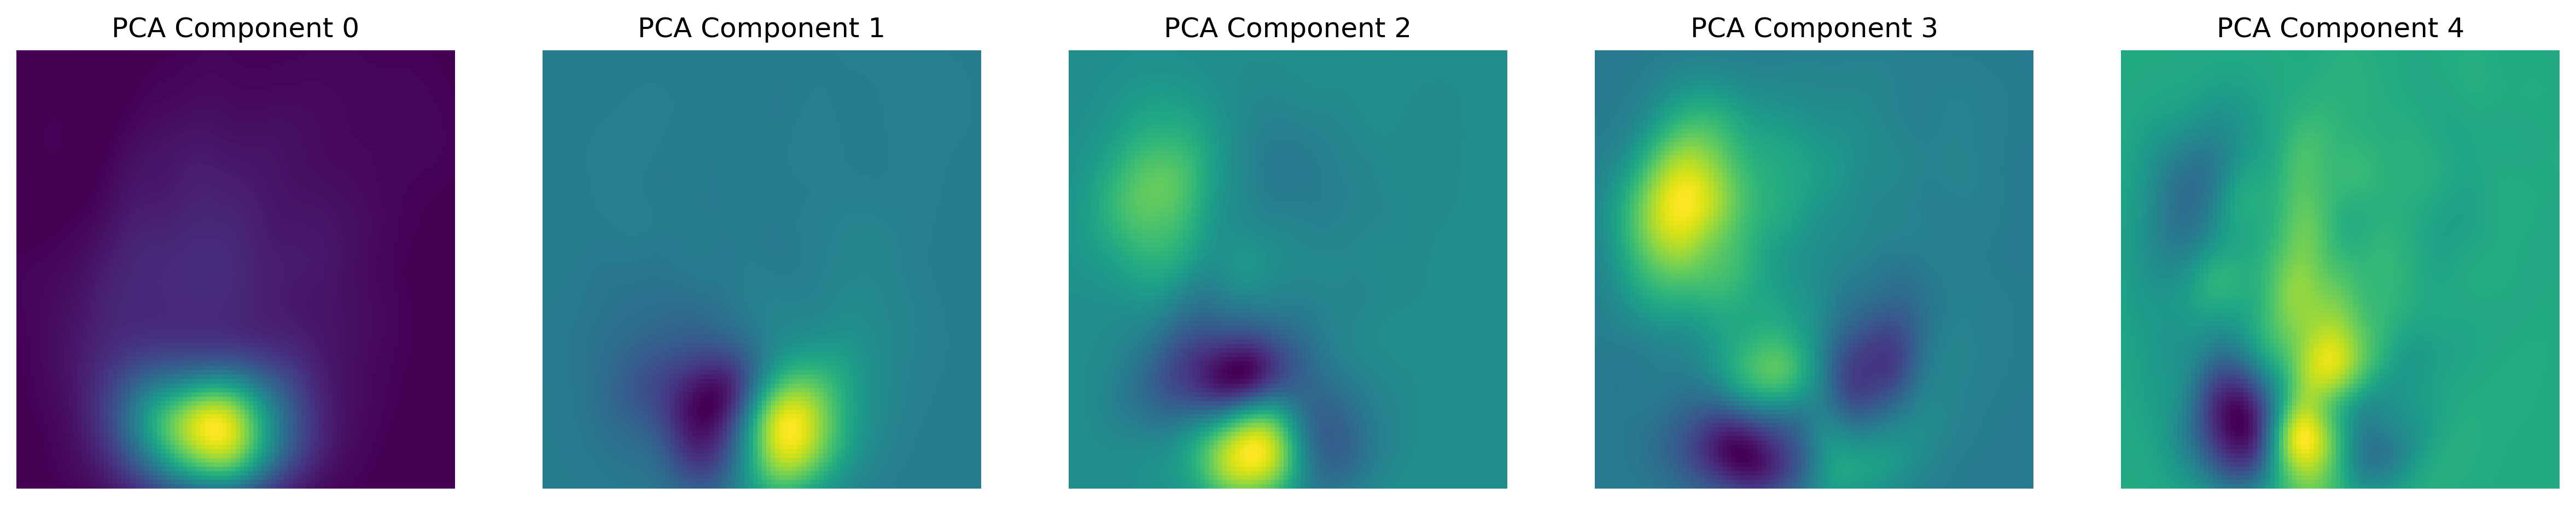

In [77]:
#Display all 5 PCA components

fig, axes = plt.subplots(1, 5, figsize=(20, 28), dpi = 300)
axes = axes.ravel()

for n in range(nc):
    ax = axes[n]
    im = ax.imshow(components[n].reshape(100,100), cmap='viridis')
    ax.set_title(f'PCA Component {n}')
    ax.axis('off')

In [78]:
loadings.shape

(35, 5)

In [79]:
loadings_sh = loadings.reshape(kde_a, kde_b,nc)

In [81]:
l1 = array_evolution[:,:,-2]
l2 = array_evolution[:,:,-1]
print(f"Z1.shape is {l1.shape}")
print(f"Z2.shape is {l2.shape}")

Z1.shape is (7, 7531)
Z2.shape is (7, 7531)


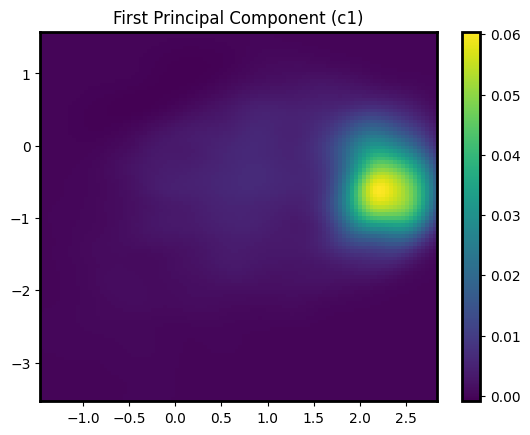

In [83]:
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Compute KDEs for each window size
kde_results = []
for i in range(l1.shape[0]):
    data = np.vstack([l1[i, :], l2[i, :]])
    kde = gaussian_kde(data)
    grid_x, grid_y = np.mgrid[data[0].min():data[0].max():100j, data[1].min():data[1].max():100j]
    kde_results.append(kde(np.vstack([grid_x.ravel(), grid_y.ravel()])).reshape(grid_x.shape))

# Step 2 & 3: Flatten, PCA and Reshape
nc = 4
kde_matrix = np.array([kde_result.ravel() for kde_result in kde_results])
pca = PCA(n_components=nc)  # Adjust components as needed
pca_results = pca.fit_transform(kde_matrix)

# Reshape PCA results for visualization
pca_components = pca.components_.reshape(-1, 100, 100)
pca_loadings = pca.transform(kde_matrix)
# Visualization of the first PCA component
plt.imshow(pca_components[0], extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()), aspect='auto')
plt.colorbar()
plt.title('First Principal Component (c1)')
plt.show()


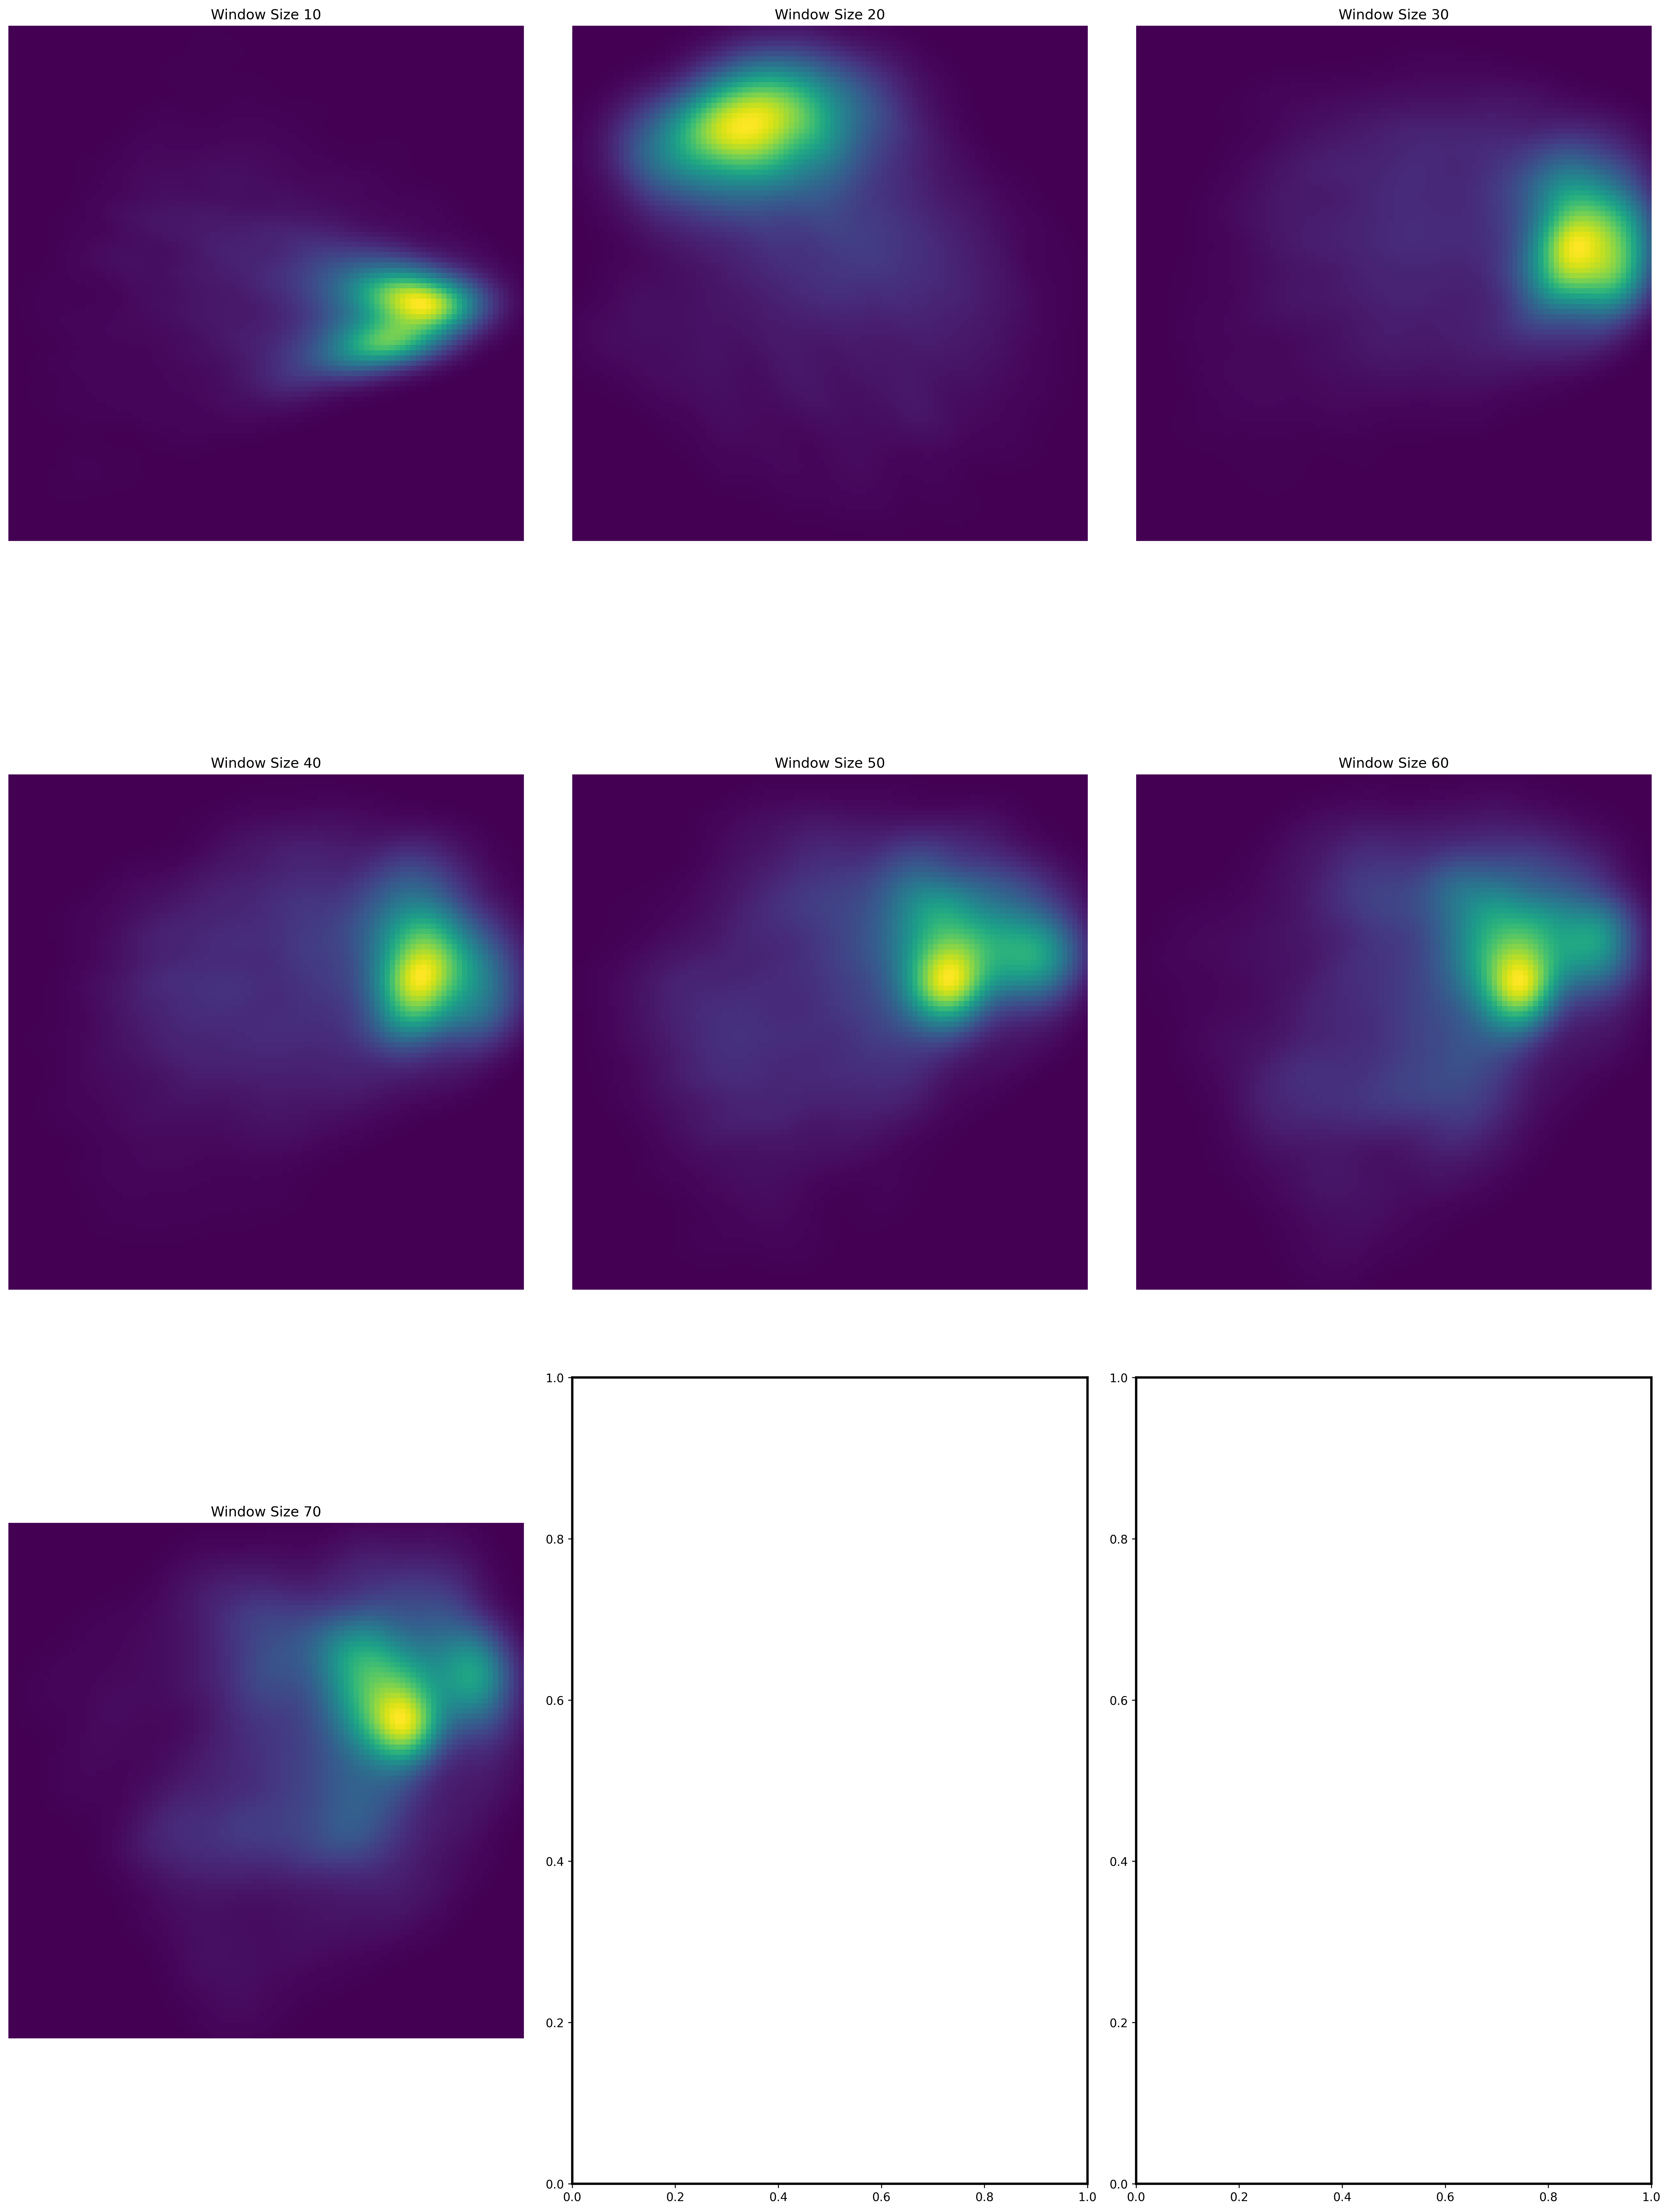

In [90]:
#Display the KDE for each window size

num_plots = l1.shape[0]
cols = int(np.ceil(np.sqrt(num_plots)))
rows = int(np.ceil(num_plots / cols))

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 28), dpi=300)
axes = axes.ravel()

for w in range(l1.shape[0]):
    ax = axes[w]
    im = ax.imshow(kde_results[w], cmap='viridis')
    ax.set_title(f'Window Size {ws[w]}')
    ax.axis('off')

plt.tight_layout()


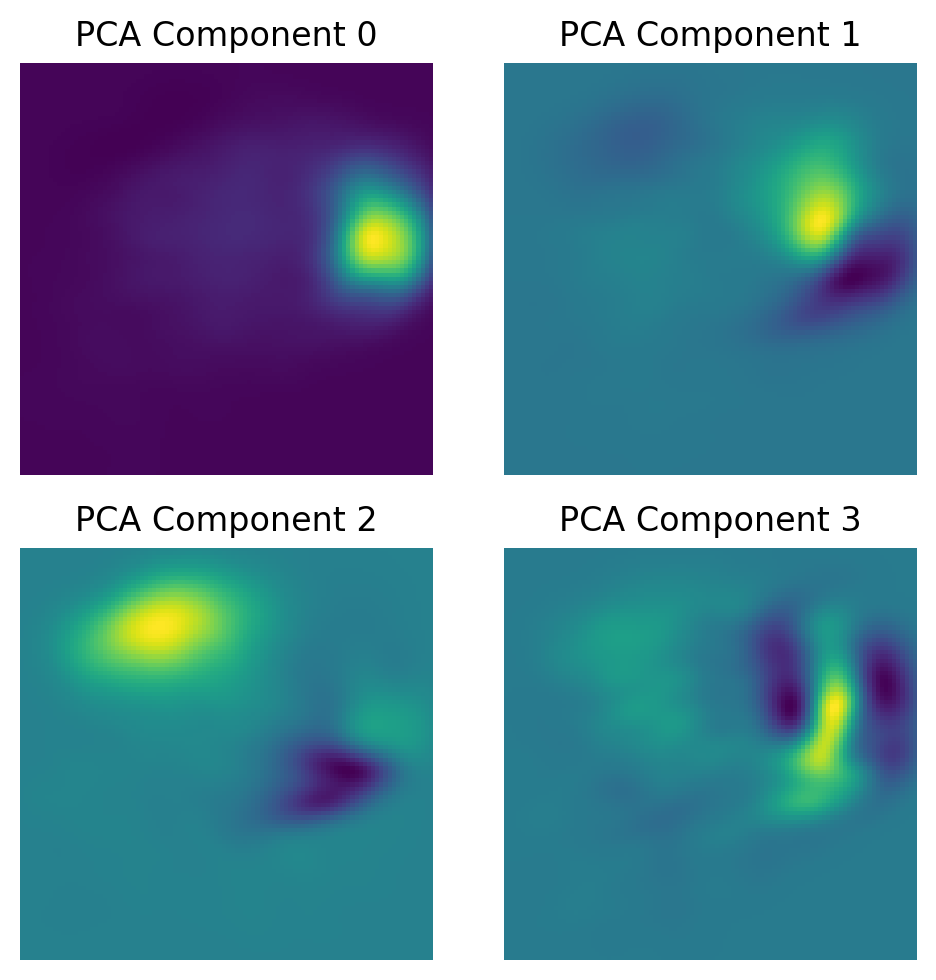

In [95]:
#Display all 5 PCA components

num_plots = nc
cols = int(np.ceil(np.sqrt(num_plots)))
rows = int(np.ceil(num_plots / cols))
fig, axes = plt.subplots(rows, cols, figsize=(5, 5), dpi = 200)
axes = axes.ravel()

for n in range(nc):
    ax = axes[n]
    im = ax.imshow(pca_components[n], cmap='viridis')
    ax.set_title(f'PCA Component {n}')
    ax.axis('off')

plt.tight_layout()

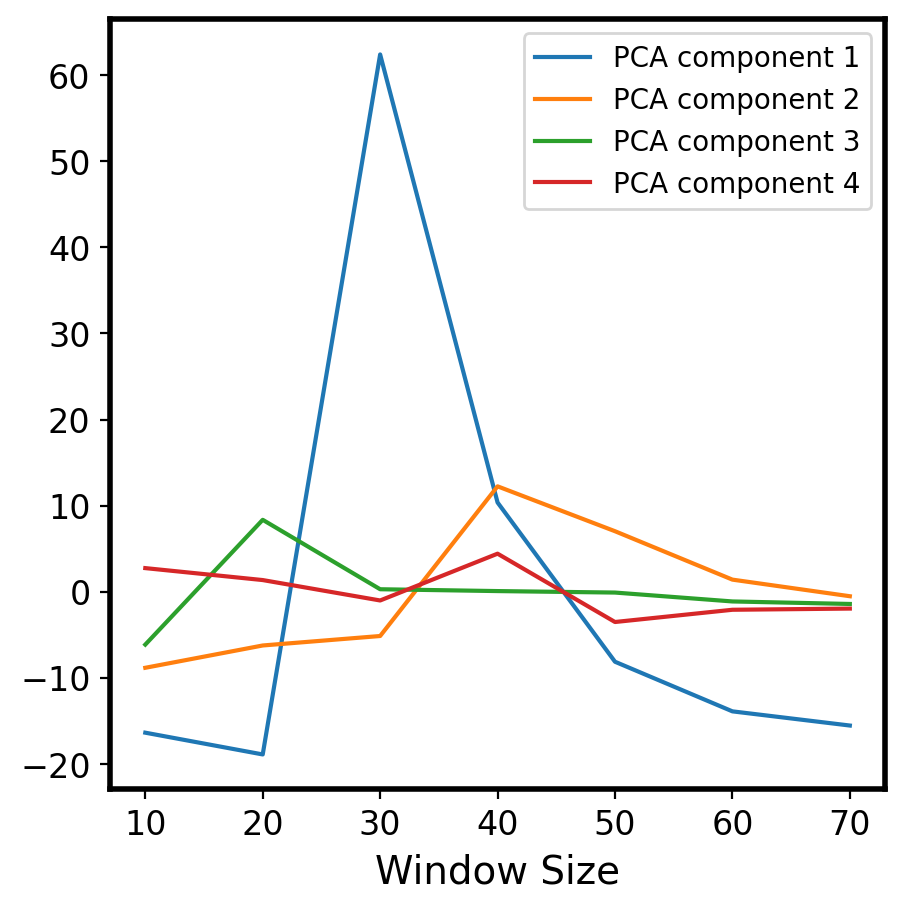

In [94]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots( figsize=(5, 5), dpi = 200)
for i in range(nc):
  plt.plot(ws,pca_loadings[:,i], label = f"PCA component {i+1}")
plt.legend(fontsize =10)
plt.xlabel("Window Size", fontsize=14)
# plt.title("Loadings Map", fontsize=14)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)


#Full VAE

In [98]:
window_size_consistent = 40
# Ititialize model
in_dim = (window_size_consistent, window_size_consistent)
rvae_super = pv.models.iVAE(in_dim, latent_dim=2,   # Number of latent dimensions other than the invariancies
                               hidden_dim_e = [512, 512],   # corresponds to the number of neurons in the hidden layers of the encoder
                               hidden_dim_d = [512, 512],   # corresponds to the number of neurons in the hidden layers of the decoder
                               invariances=['r', 't'], seed=0)
# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(rvae_super)


In [99]:
rvae_super.load_weights("/content/weight_running_VAE.pt")

In [100]:
array_evolution = []
mean_z = []
mean_z_w = []
disperse_z = []
disperse_z_w = []
for i,j in tqdm(enumerate(ws)):
    print("data curation started")
    s = get_s(lattice_coord_largest, j, decoded_imgs)
    imstack, frames_all, com_all = get_imstack_frames_com_all(s, j)
    resized_imstack = resize_image_stack(imstack, size=(40, 40))
    final_train, final_trainloader = get_data_loader(resized_imstack, batch_size = 120)
    print("data curation ended, shape=", imstack.shape, frames_all.shape, com_all.shape)
    print("window_size", j)

    z_mean, z_sd = rvae_super.encode(final_train)
    array_evolution.append(z_mean)
    # plot latent manifold:
    get_custom_manifold2d(rvae_super,d = 9, ws = j);   # d corresponds to the number of points sampled in each latent dimension
    # plot latent rep
    plot_latent_rep_with_kde(z_mean, z_sd, ws = j,  folder = "dist")
    # plot latent images
    # z1, z2, z3 = z_mean[:,0], z_mean[:, 1:3], z_mean[:, 3:]
    # visualize_latent_images(0, com_all, frames_all, lattice_coord, z1, z3, STEM_real, ws =j, folder = "latent_img")#lattice_coord_largest_ws

    # visualize_latent_images(2, com_all, frames_all, lattice_coord, z1, z3, STEM_real, ws =j)
    # visualize_latent_images(4, com_all, frames_all, lattice_coord, z1, z3, STEM_real, ws =j)

rvae_super.save_weights(f"weight_running_VAE")
np.savez(f"array_evolution.npz", array_evolution= np.array(array_evolution))
# files.download(f"/content/array_evolution{j}.npz")

Output hidden; open in https://colab.research.google.com to view.

In [102]:
np.savez("array_evolution_fullVAE.npz", array_evolution= np.array(array_evolution))

# Now postprocessing evolution of window size

In [104]:
array_evolution = np.load("/content/array_evolution_fullVAE.npz")["array_evolution"]
array_evolution.shape

(7, 7531, 5)

In [105]:
array_evolution = np.array(array_evolution)

Text(0, 0.5, 'Angle encoding')

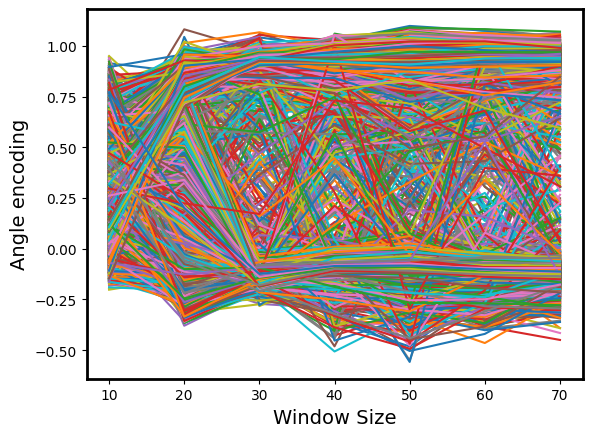

In [106]:
plt.plot(ws, array_evolution[:,:,0]);
plt.xlabel("Window Size", fontsize = 14)
plt.ylabel("Angle encoding", fontsize = 14)
# Adding a title to the plot
# plt.title("Evolution of Angle Latent Variables for all atoms")

Text(0, 0.5, 'Translation - X encoding')

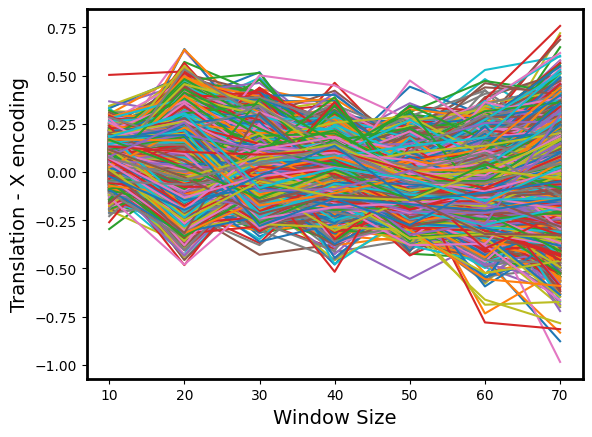

In [107]:
plt.plot(ws, array_evolution[:,:,1]);
plt.xlabel("Window Size", fontsize = 14)
plt.ylabel("Translation - X encoding", fontsize = 14)
# Adding a title to the plot
# plt.title("Evolution of translation-X Latent Variables for all atoms")

Text(0, 0.5, 'Translation - Y encoding')

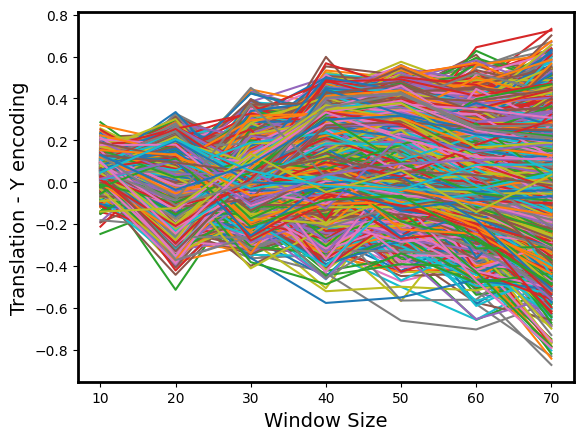

In [108]:
plt.plot(ws, array_evolution[:,:,2]);
plt.xlabel("Window Size", fontsize = 14)
plt.ylabel("Translation - Y encoding", fontsize = 14)
# Adding a title to the plot
# plt.title("Evolution of translation-Y Latent Variables for all atoms")

Text(0, 0.5, 'L1')

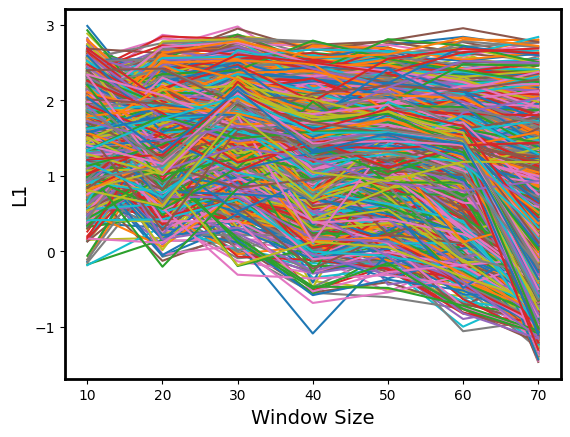

In [109]:
plt.plot(ws, array_evolution[:,:,3]);
plt.xlabel("Window Size", fontsize = 14)
plt.ylabel("L1", fontsize = 14)
# Adding a title to the plot
# plt.title("Evolution of 1st Latent Variables for all atoms")

Text(0, 0.5, 'L2')

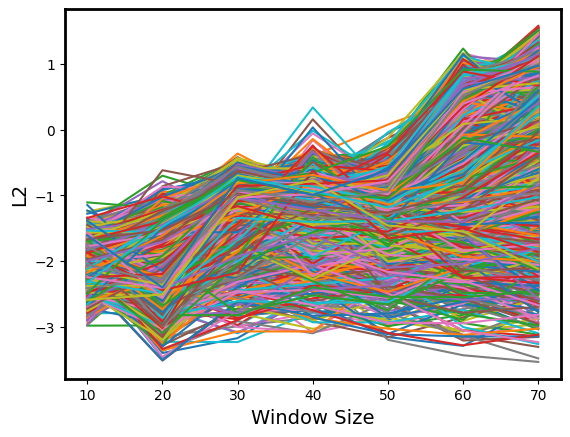

In [110]:
plt.plot(ws, array_evolution[:,:,4]);
plt.xlabel("Window Size", fontsize = 14)
plt.ylabel("L2", fontsize = 14)
# Adding a title to the plot
# plt.title("Evolution of 2nd Latent Variables for all atoms")

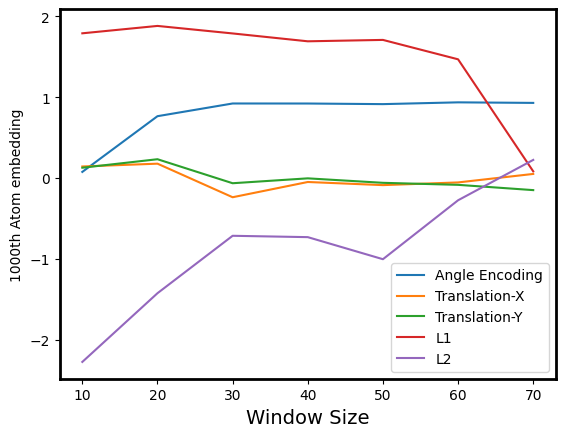

In [111]:
# plot evolution of the 1000th atom
chosen_atom = 1000
latent_variable_labels = ['Angle Encoding', 'Translation-X', 'Translation-Y', 'L1', 'L2']

for i in range(5):
    plt.plot(ws,array_evolution[:, chosen_atom - 1, i], label=f"{latent_variable_labels[i]}")

# Labeling the axes
plt.xlabel("Window Size", fontsize = 14)
plt.ylabel("1000th Atom embedding", )

# Adding a legend
plt.legend(loc='best')

# Adding a title to the plot
# plt.title("Evolution of Latent Variables for Atom #1000")

# Show the plot
plt.show()


In [112]:
array_evolution.shape

(7, 7531, 5)

In [113]:
frames_all.shape

(7531,)

In [114]:
mean_z = []
mean_z1_w = []
disperse_z = []
disperse_z1_w = []
z1 = array_evolution[:,:,-2]
for w in range(7):
  mean_z = []
  disperse_z = []
  for frame in np.unique(frames_all):

    frame_data = z1[w, frames_all == frame]  # Select data points for the current frame
    mean_vector, variance_array = frame_data.mean(), frame_data.var()
    mean_z.append(mean_vector)# 50
    disperse_z.append(variance_array)
  mean_z1_w.append(mean_z)
  disperse_z1_w.append(disperse_z)

In [115]:
mean_z = []
mean_z2_w = []
disperse_z = []
disperse_z2_w = []
z1 = array_evolution[:,:,-1]
for w in range(7):
  mean_z = []
  disperse_z = []
  for frame in np.unique(frames_all):

    frame_data = z1[w, frames_all == frame]  # Select data points for the current frame
    # frame_data = frame_data.detach().cpu().numpy()
    # mean_vector, variance_array = calculate_dispersion(frame_data)
    mean_vector, variance_array = frame_data.mean(), frame_data.var()
    mean_z.append(mean_vector)# 50
    disperse_z.append(variance_array)
  mean_z2_w.append(mean_z)
  disperse_z2_w.append(disperse_z)

In [116]:
mean_z1_w = np.array(mean_z1_w)
disperse_z1_w = np.array(disperse_z1_w)
mean_z2_w = np.array(mean_z2_w)
disperse_z2_w = np.array(disperse_z2_w)

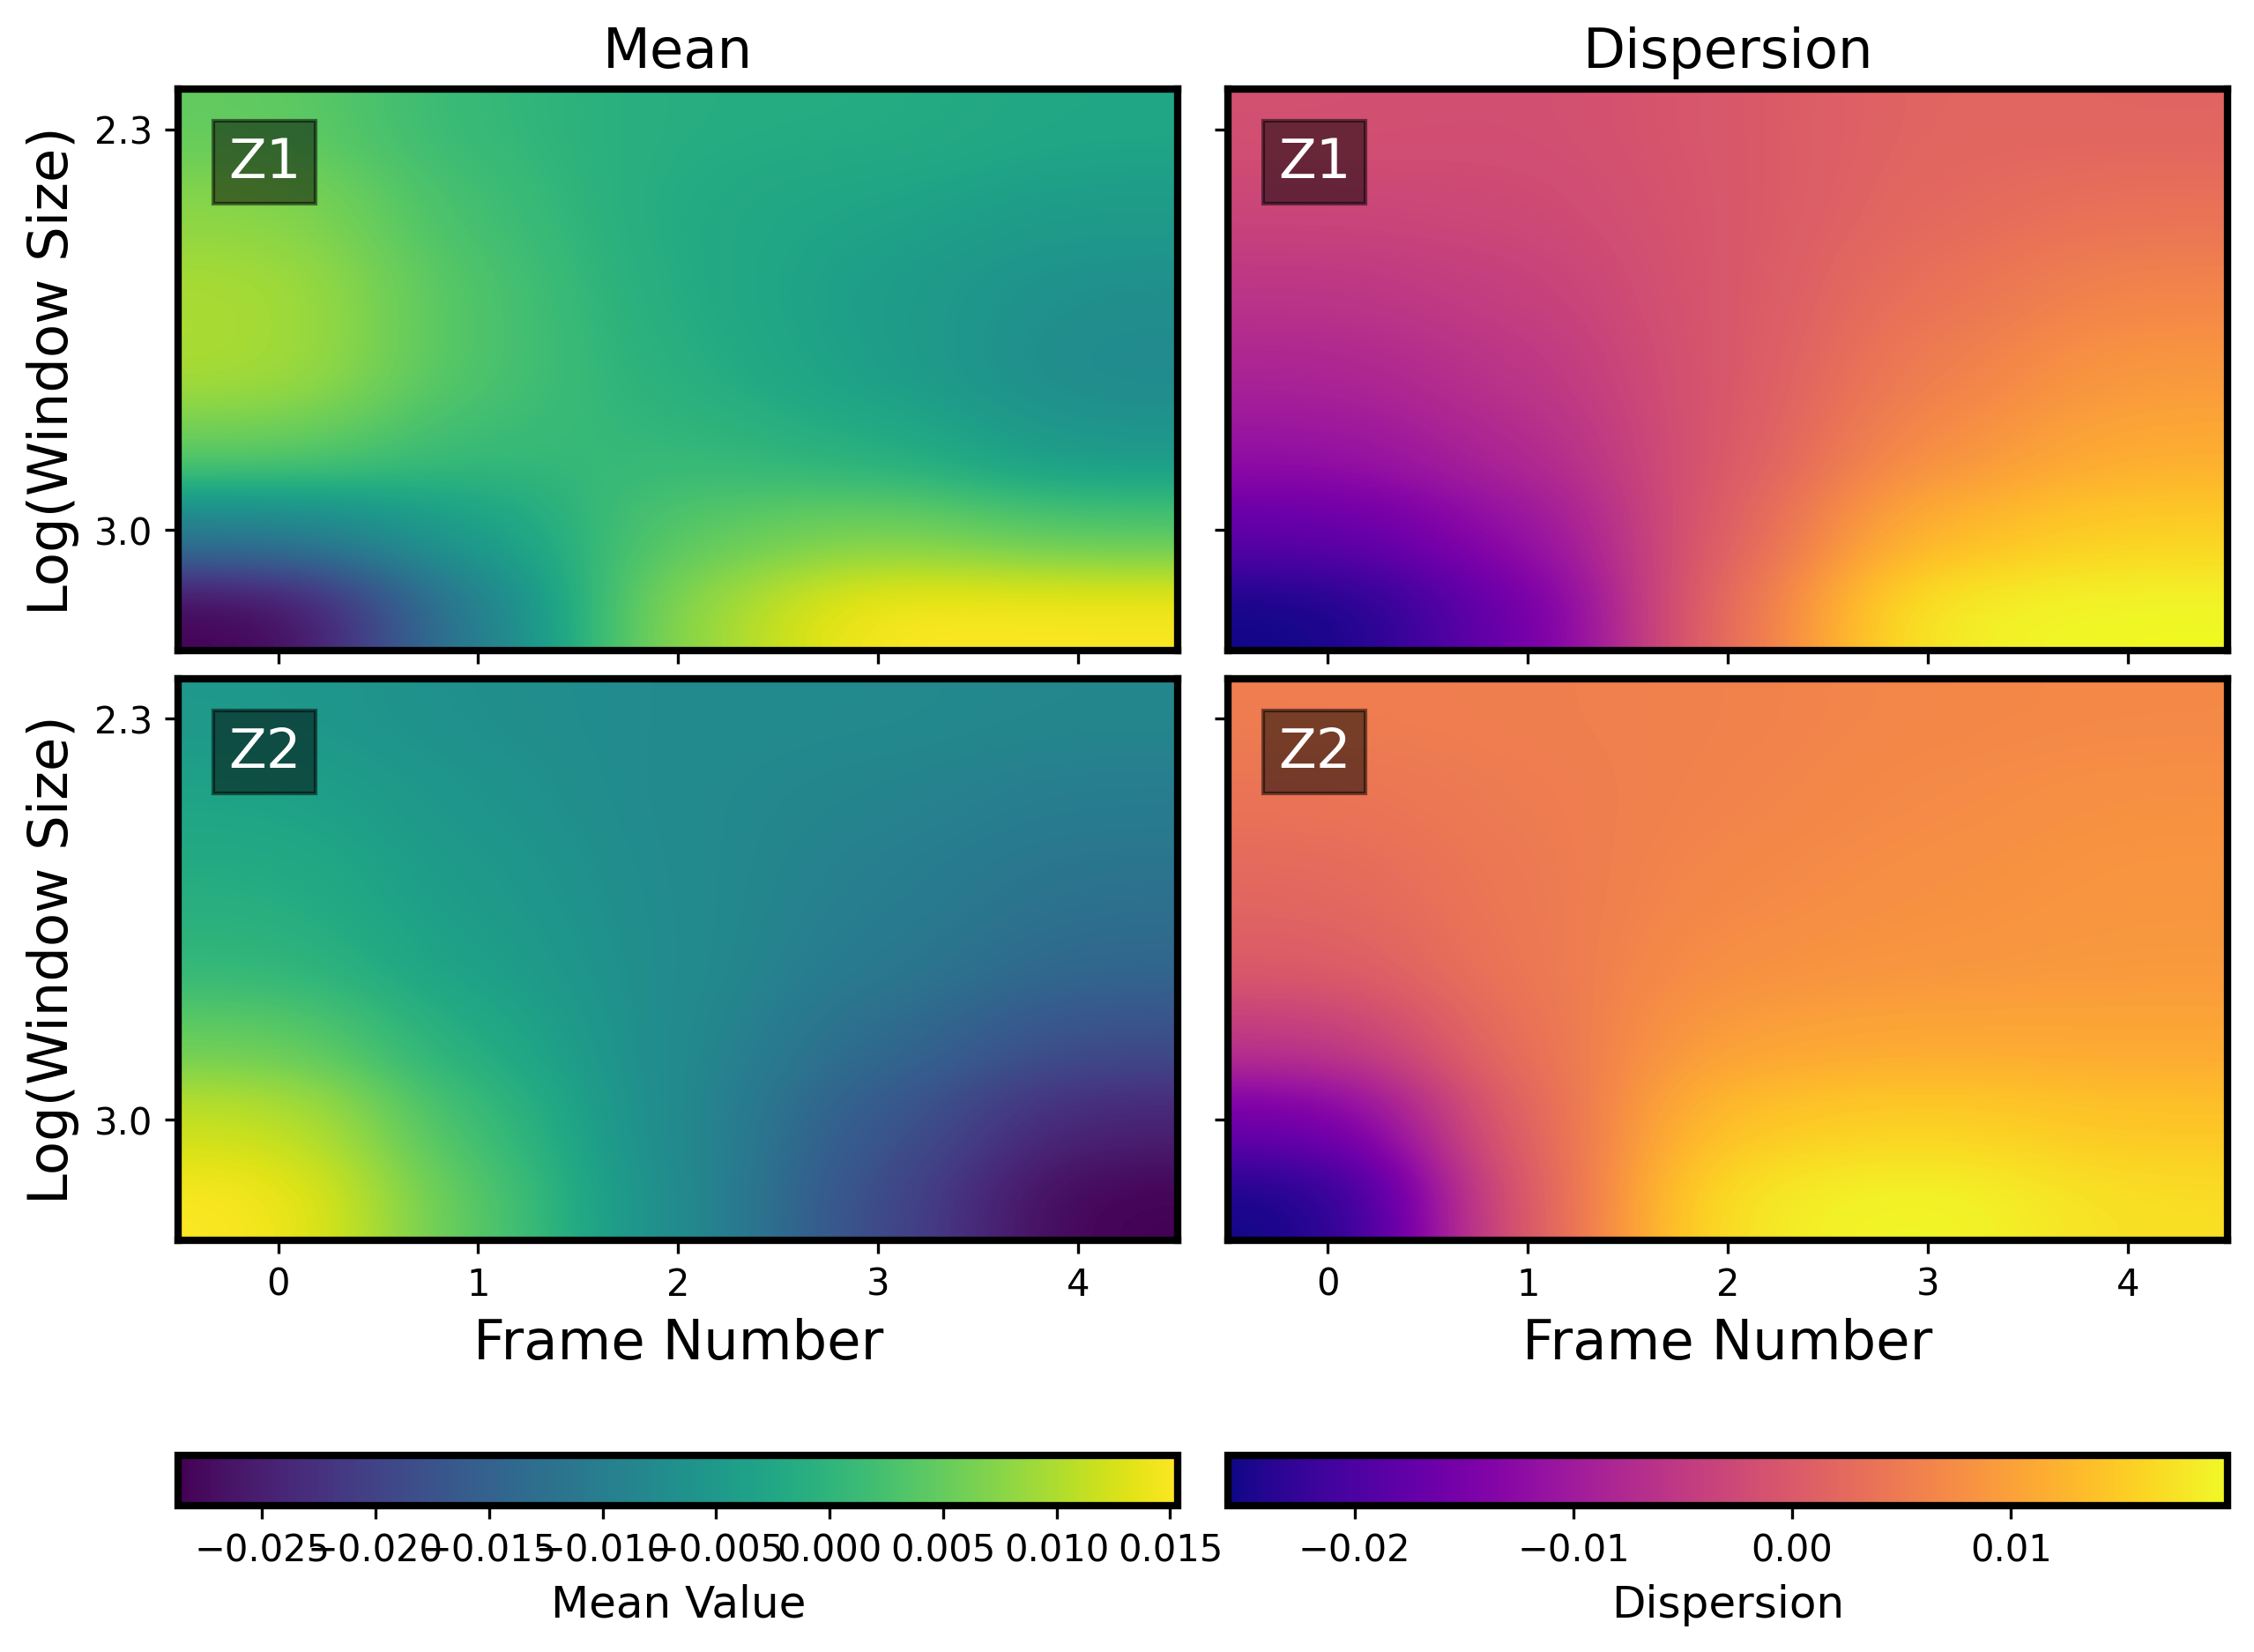

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Function to subtract the mean of each line
def subtract_line_mean(data):
    mean_subtracted = data - np.mean(data, axis=1, keepdims=True)
    return mean_subtracted

log_window_sizes = np.log(ws)
step = 5


# Subtract the mean of each line to highlight variations
mean_z1_w_subtracted = subtract_line_mean(mean_z1_w)
mean_z2_w_subtracted = subtract_line_mean(mean_z2_w)
disperse_z1_w_subtracted = subtract_line_mean(disperse_z1_w)
disperse_z2_w_subtracted = subtract_line_mean(disperse_z2_w)

# Apply Gaussian filter for smoothing
sigma = 1  # Adjust sigma for smoothing effect
mean_z1_w_smooth = gaussian_filter(mean_z1_w_subtracted, sigma=sigma)
mean_z2_w_smooth = gaussian_filter(mean_z2_w_subtracted, sigma=sigma)
disperse_z1_w_smooth = gaussian_filter(disperse_z1_w_subtracted, sigma=sigma)
disperse_z2_w_smooth = gaussian_filter(disperse_z2_w_subtracted, sigma=sigma)

fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=300, sharex=True, sharey=True)

# Mean plot 1
im1 = axes[0, 0].imshow(mean_z1_w_smooth, interpolation='gaussian', cmap='viridis')
axes[0, 0].set_aspect('auto')
axes[0, 0].set_ylabel('Log(Window Size)', fontsize=15)
yticks = range(0, mean_z1_w.shape[0], step)
axes[0, 0].set_yticks(yticks)
axes[0, 0].set_yticklabels(np.round(log_window_sizes[:len(yticks)], 2))
axes[0, 0].set_title('Mean', fontsize=15)
# axes[0, 0].grid(True, linestyle='--', alpha=0.5)
axes[0, 0].text(-0.25, 0.6, 'Z1', fontsize=15, color='white', bbox=dict(facecolor='black', alpha=0.5))

# Mean plot 2
im2 = axes[1, 0].imshow(mean_z2_w_smooth, interpolation='gaussian', cmap='viridis')
axes[1, 0].set_aspect('auto')
axes[1, 0].set_ylabel('Log(Window Size)', fontsize=15)
axes[1, 0].set_xlabel('Frame Number', fontsize=15)
# axes[1, 0].grid(True, linestyle='--', alpha=0.5)
axes[1, 0].text(-0.25, 0.6, 'Z2', fontsize=15, color='white', bbox=dict(facecolor='black', alpha=0.5))

# Dispersion plot 1
im3 = axes[0, 1].imshow(disperse_z1_w_smooth, interpolation='gaussian', cmap='plasma')
axes[0, 1].set_aspect('auto')
axes[0, 1].set_title('Dispersion', fontsize=15)
# axes[0, 1].grid(True, linestyle='--', alpha=0.5)
axes[0, 1].text(-0.25, 0.6, 'Z1', fontsize=15, color='white', bbox=dict(facecolor='black', alpha=0.5))

# Dispersion plot 2
im4 = axes[1, 1].imshow(disperse_z2_w_smooth, interpolation='gaussian', cmap='plasma')
axes[1, 1].set_aspect('auto')
axes[1, 1].set_xlabel('Frame Number', fontsize=15)
# axes[1, 1].grid(True, linestyle='--', alpha=0.5)
axes[1, 1].text(-0.25, 0.6, 'Z2', fontsize=15, color='white', bbox=dict(facecolor='black', alpha=0.5))

# Adjust layout
plt.subplots_adjust(hspace=0.05, wspace=0.05, bottom=0.2)

# Add colorbars at the bottom
cbar1 = fig.colorbar(im1, ax=[axes[0, 0], axes[1, 0]], orientation='horizontal', fraction=0.05, pad=0.15, shrink=1)
cbar2 = fig.colorbar(im3, ax=[axes[0, 1], axes[1, 1]], orientation='horizontal', fraction=0.05, pad=0.15, shrink=1)

cbar1.set_label('Mean Value', fontsize=12)
cbar2.set_label('Dispersion', fontsize=12)

plt.show()


# Further lets do some dimensionality reduction to get important features and visualize them on atoms
idea is to play with two variables:
1. choose a random variable-> rv = 1 [ranges from 0 to 4 for rtvae]

2. play with nc in dimension reduction

3. visualizing the frames with feature values on each atom

## 1. choose a random variable -> rv = 1 [ranges from 0 to 4 for rtvae]

In [118]:
array_evolution_transposed  = array_evolution.transpose(1, 2, 0)
print(array_evolution_transposed.shape)

X_vec = array_evolution_transposed.copy()
d1, d2, d3 = X_vec.shape

# choose a random variable
rv = 4
X_vec = X_vec[:, rv, :]# chosen a latent variable
print("shape of features to undergo dimensionality reduction", X_vec.shape)

(7531, 5, 7)
shape of features to undergo dimensionality reduction (7531, 7)


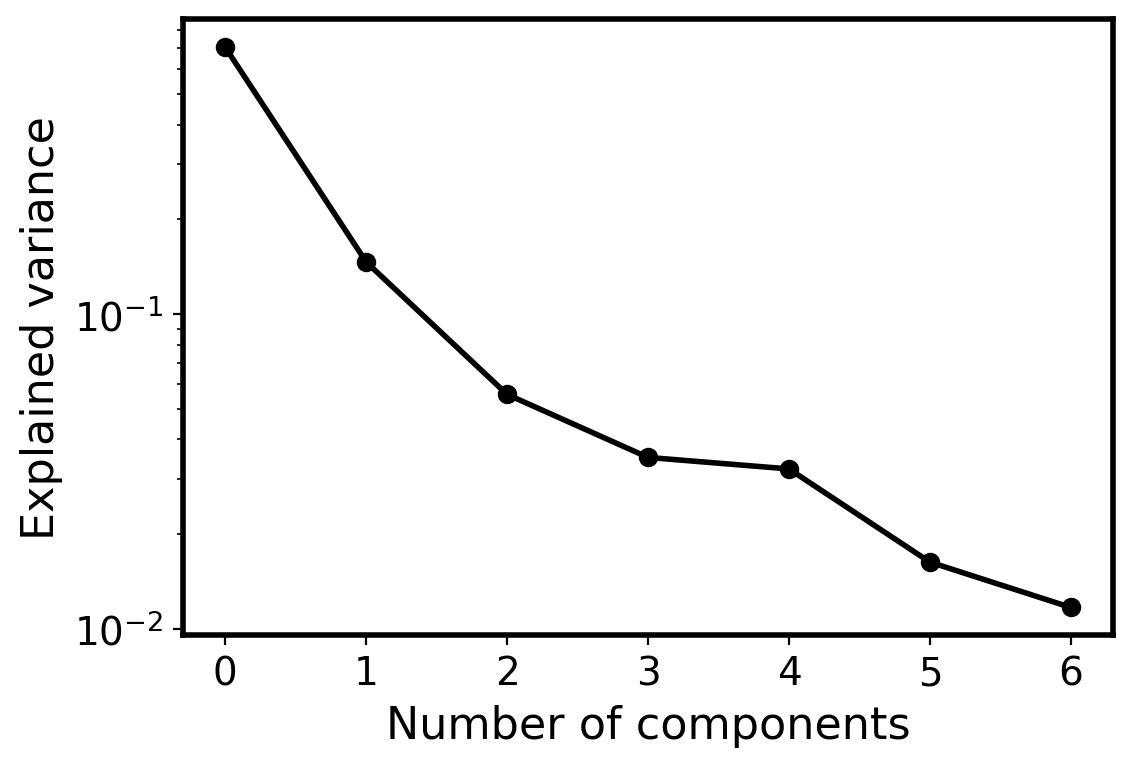

In [119]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 7)
pca.fit(X_vec)
plt.figure(figsize=(6, 4), dpi = 200)
plt.plot(pca.explained_variance_ratio_[0:150], '-o', linewidth=2, c = 'black')
plt.xlabel('Number of components', fontsize = 16)
plt.ylabel('Explained variance', fontsize = 16)

plt.tick_params(labelsize = 14)
plt.yscale('log')

## 2. play with nc in dimension reduction -> default 10

In [120]:
# Select number of components
nc = 7

# Select decomposition type ('PCA' or 'NMF')
decomposition_type = 'PCA'

# Run decomposition
if decomposition_type == 'NMF':
    clf = decomposition.NMF(n_components=nc, random_state=42)
elif decomposition_type == 'PCA':
    clf = decomposition.PCA(n_components=nc, random_state=42)
else:
    raise NotImplementedError('Available methods: "PCA", "NMF"')
X_vec_t = clf.fit_transform(X_vec)
components = clf.components_
#components = components.reshape(nc, d3)
print(components.shape, X_vec_t.shape)

(7, 7) (7531, 7)


## 3. visualizing the frame with feature values on each atom-> choose a, b and c

In [123]:
### Angle encoding
# here you can choose any varibles from
#choose_indexs
a, b, c = 0, 1, 2# can be values b/w 0 t0 nc --> here nc = 10

z1, z2, z3 = X_vec_t[:, a], X_vec_t[:, b], X_vec_t[:, c]#
visualize_on_atoms(0, com_all, frames_all, lattice_coord, z1, z2, z3, STEM_real, ws ="_all_")#lattice_coord_largest_ws

Output hidden; open in https://colab.research.google.com to view.

## KDE -> PCA

In [124]:
array_evolution.shape

(7, 7531, 5)

In [125]:
# Extract the last two latent variables
z1 = array_evolution[:, :, -2]
z2 = array_evolution[:, :, -1]
print(z1.shape)

(7, 7531)


In [126]:
frames_all.shape

(7531,)

In [127]:
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def calculate_kde(z1, z2, grid_size=100):
    # Create grid for evaluation
    x_grid = np.linspace(z1.min(), z1.max(), grid_size)
    y_grid = np.linspace(z2.min(), z2.max(), grid_size)
    X, Y = np.meshgrid(x_grid, y_grid)
    grid_coords = np.vstack([X.ravel(), Y.ravel()])

    # Calculate KDE
    kde = stats.gaussian_kde(np.vstack([z1, z2]))
    Z = kde(grid_coords).reshape(grid_size, grid_size)

    return Z

# Initialize a list to store KDEs for each window size and frame
kdes = []

for w in range(z1.shape[0]):
    frame_kdes = []
    for frame in np.unique(frames_all):
        # Filter patches by frame
        z1_patch = z1[w, frames_all == frame]
        z2_patch = z2[w, frames_all == frame]

        kde = calculate_kde(z1_patch, z2_patch)
        frame_kdes.append(kde)

    kdes.append(frame_kdes)

kdes = np.array(kdes)


In [128]:
kdes.shape

(7, 5, 100, 100)

In [129]:
# Reshape KDEs for PCA
kde_a, kde_b  =  kdes.shape[0], kdes.shape[1]
flattened_kdes = kdes.reshape(kde_a*kde_b, -1)  # Shape: (35, 50, 10000)

# Run PCA over time
nc = 5
pca = PCA(n_components=nc)  # Number of components can be adjusted
components = []
loadings = []

pca.fit(flattened_kdes)
components = pca.components_
loadings = pca.transform(flattened_kdes)

components = np.array(components)  # Shape: (35, 5, 10000)
loadings = np.array(loadings)  # Shape: (35, 50, 5)


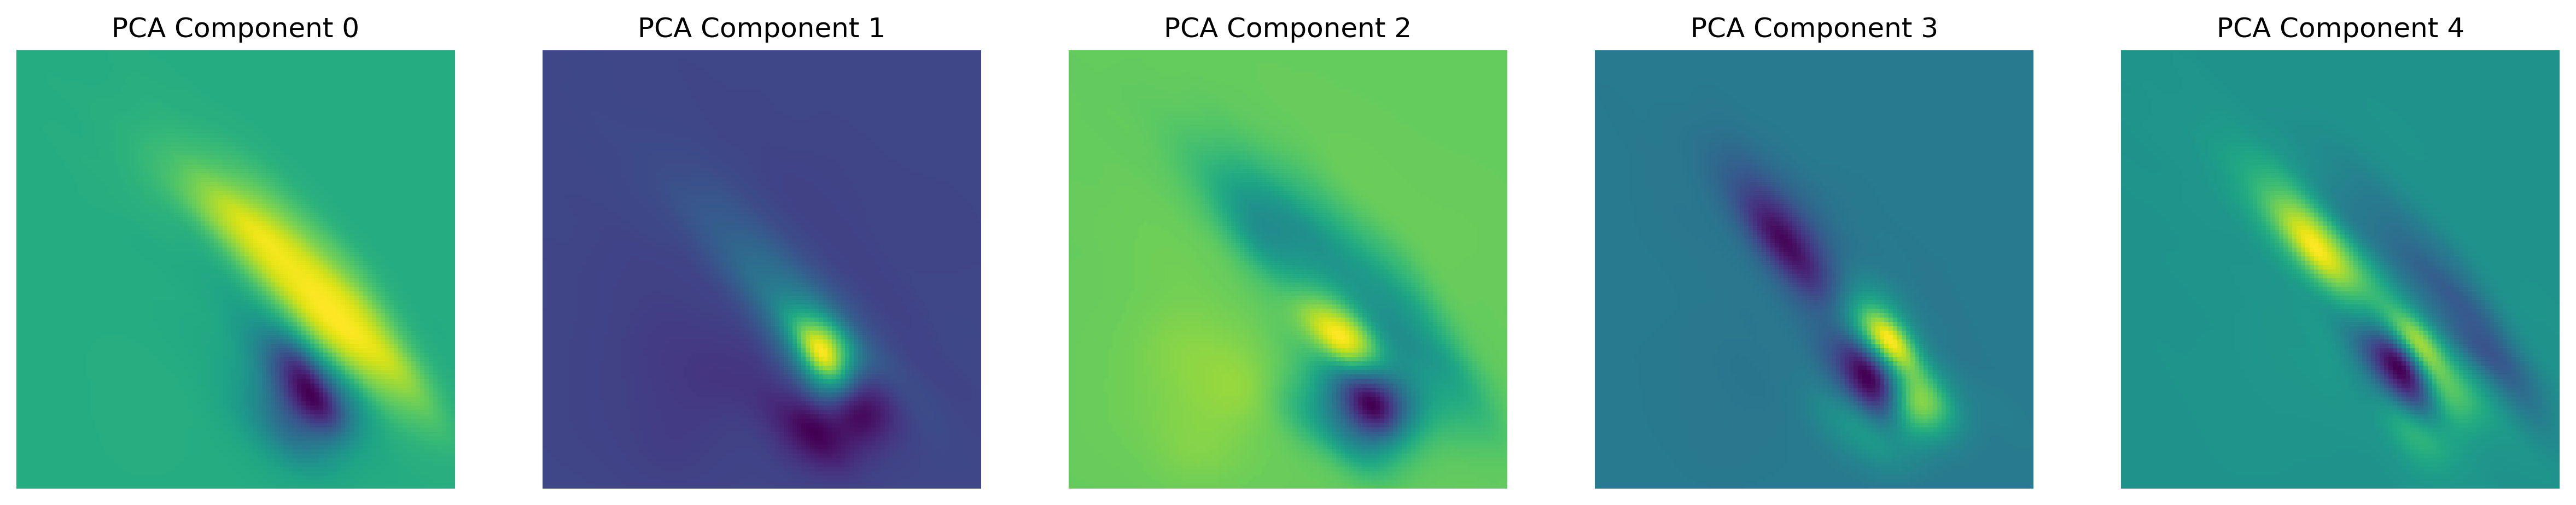

In [130]:
#Display all 5 PCA components

fig, axes = plt.subplots(1, 5, figsize=(20, 28), dpi = 300)
axes = axes.ravel()

for n in range(nc):
    ax = axes[n]
    im = ax.imshow(components[n].reshape(100,100), cmap='viridis')
    ax.set_title(f'PCA Component {n}')
    ax.axis('off')

In [131]:
loadings.shape

(35, 5)

In [132]:
loadings_sh = loadings.reshape(kde_a, kde_b,nc)

In [133]:
l1 = array_evolution[:,:,-2]
l2 = array_evolution[:,:,-1]
print(f"Z1.shape is {l1.shape}")
print(f"Z2.shape is {l2.shape}")

Z1.shape is (7, 7531)
Z2.shape is (7, 7531)


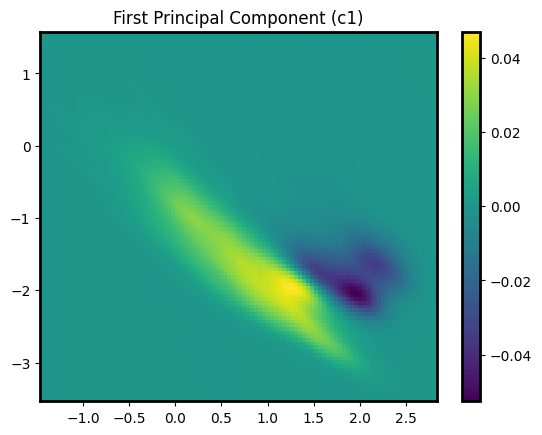

In [134]:
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Compute KDEs for each window size
kde_results = []
for i in range(l1.shape[0]):
    data = np.vstack([l1[i, :], l2[i, :]])
    kde = gaussian_kde(data)
    grid_x, grid_y = np.mgrid[data[0].min():data[0].max():100j, data[1].min():data[1].max():100j]
    kde_results.append(kde(np.vstack([grid_x.ravel(), grid_y.ravel()])).reshape(grid_x.shape))

# Step 2 & 3: Flatten, PCA and Reshape
nc = 4
kde_matrix = np.array([kde_result.ravel() for kde_result in kde_results])
pca = PCA(n_components=nc)  # Adjust components as needed
pca_results = pca.fit_transform(kde_matrix)

# Reshape PCA results for visualization
pca_components = pca.components_.reshape(-1, 100, 100)
pca_loadings = pca.transform(kde_matrix)
# Visualization of the first PCA component
plt.imshow(pca_components[0], extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()), aspect='auto')
plt.colorbar()
plt.title('First Principal Component (c1)')
plt.show()


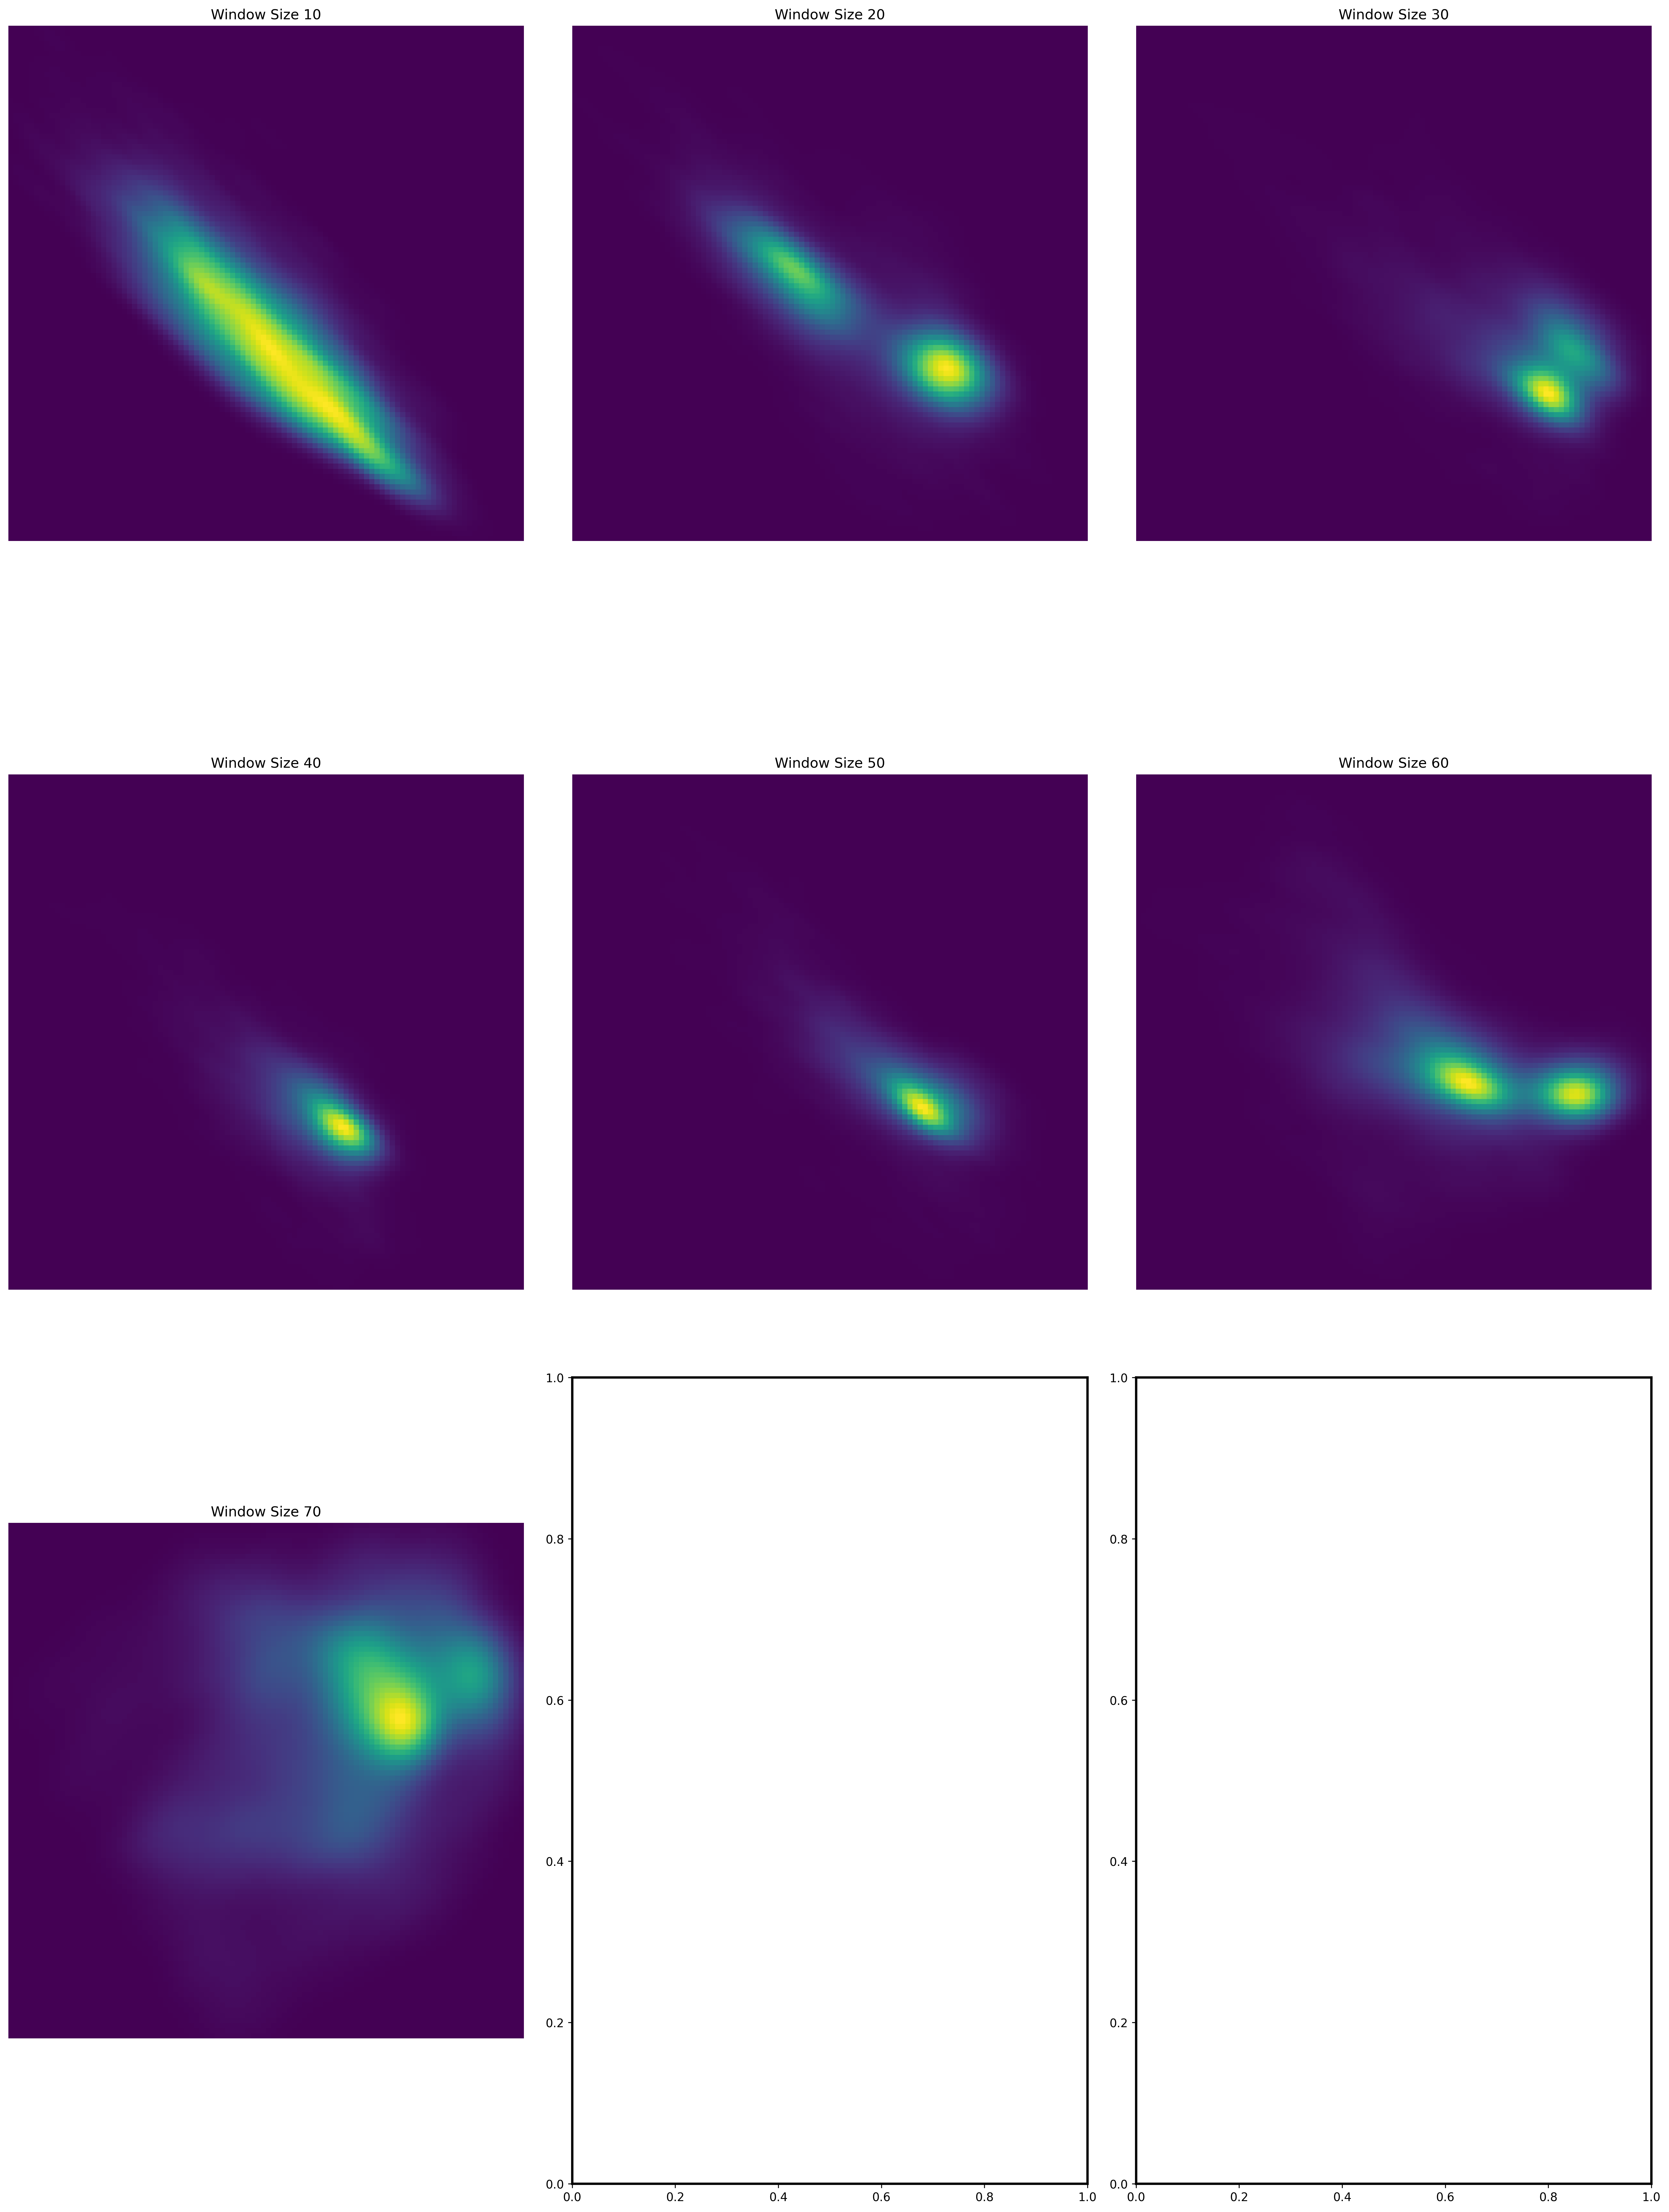

In [135]:
#Display the KDE for each window size

num_plots = l1.shape[0]
cols = int(np.ceil(np.sqrt(num_plots)))
rows = int(np.ceil(num_plots / cols))

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 28), dpi=300)
axes = axes.ravel()

for w in range(l1.shape[0]):
    ax = axes[w]
    im = ax.imshow(kde_results[w], cmap='viridis')
    ax.set_title(f'Window Size {ws[w]}')
    ax.axis('off')

plt.tight_layout()


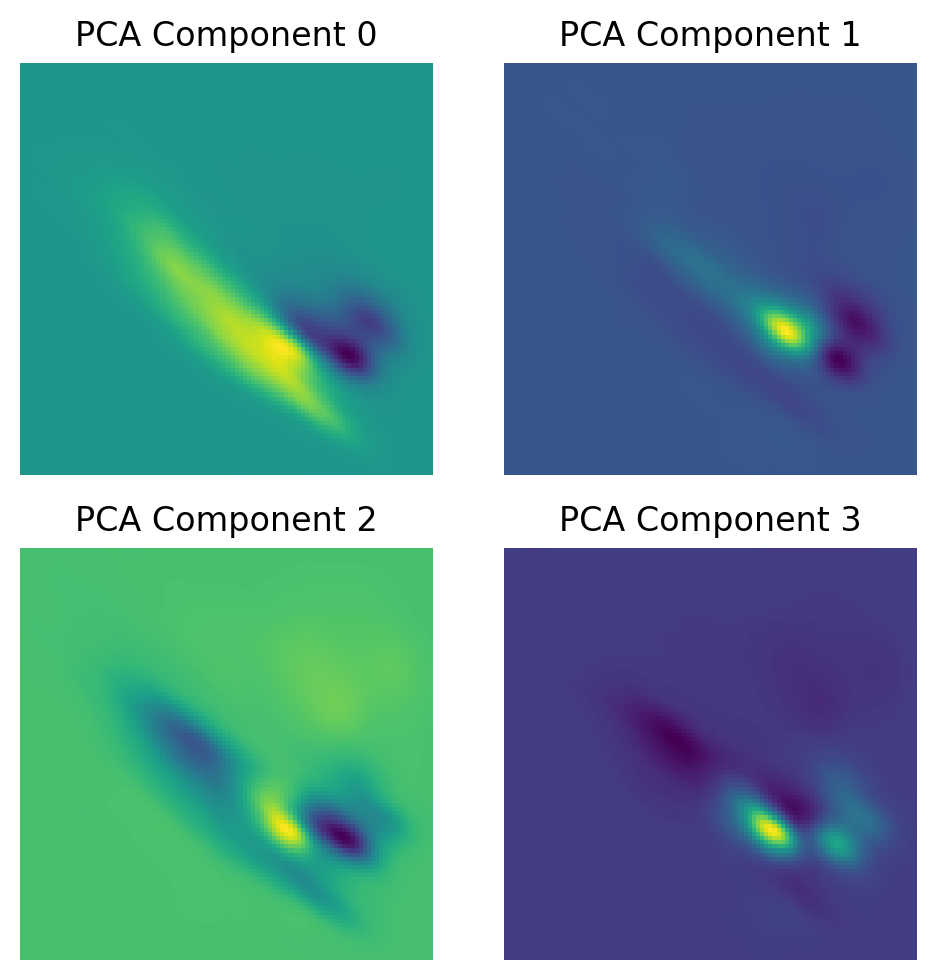

In [136]:
#Display all 5 PCA components

num_plots = nc
cols = int(np.ceil(np.sqrt(num_plots)))
rows = int(np.ceil(num_plots / cols))
fig, axes = plt.subplots(rows, cols, figsize=(5, 5), dpi = 200)
axes = axes.ravel()

for n in range(nc):
    ax = axes[n]
    im = ax.imshow(pca_components[n], cmap='viridis')
    ax.set_title(f'PCA Component {n}')
    ax.axis('off')

plt.tight_layout()

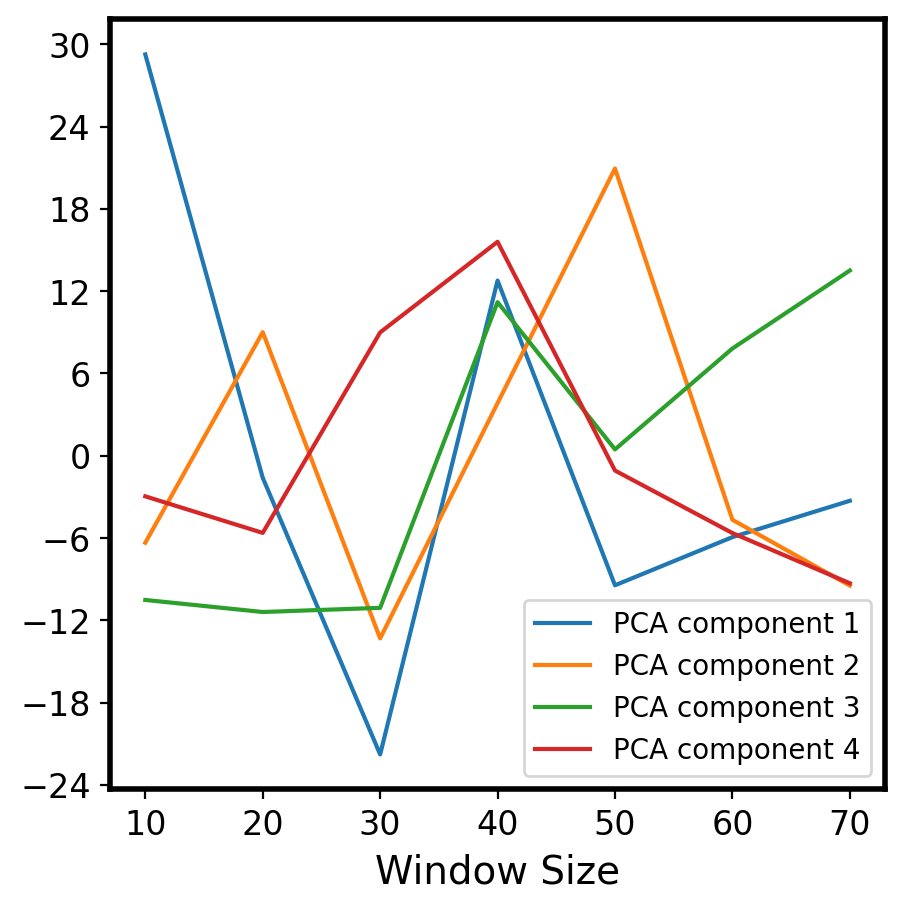

In [137]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots( figsize=(5, 5), dpi = 200)
for i in range(nc):
  plt.plot(ws,pca_loadings[:,i], label = f"PCA component {i+1}")
plt.legend(fontsize =10)
plt.xlabel("Window Size", fontsize=14)
# plt.title("Loadings Map", fontsize=14)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
